# Complete SOH Battery Analysis

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import seaborn as sns
import json
import glob
import random
from copy import deepcopy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, to_rgb, to_rgba

import tensorflow as tf
from Fitting_algo_v3 import *
from ECM_impedance_v3 import *

## Load Battery Info JSON

In [4]:
battery_json_file = "../../EVC_EIS_Data/original_data/Battery_Info.json" # Check the path

with open(battery_json_file, "r") as f:
    battery_metadata = json.load(f)   # <--- this is now a dict

In [5]:
# Review current documented batteries
print(battery_metadata.keys())

dict_keys(['CELL042'])


## Build Battery Data from EIS

In [6]:
def format_EIS(input_file):
    """
    Load EIS input csv and return a list of dictionary indexed by soc_index.

    Parameters
    ----------
    input_file : str
        csv file path of original EIS data, required to have columns ['time/s', 'I/mA', 'Ewe/V', 'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'z cycle'].
    
    Returns
    ----------
    grouped_list : [{soc_dict}], a list of SOC dictionaries. soc_dict has attributes: freq, angular_freq, Z_mag, phase_deg, Z_real, Z_imag.
    """
    df = pd.read_csv(input_file)

    # Ensure relevant columns exist
    required = ['time/s', 'I/mA', 'Ewe/V', 'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'z cycle']
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Ensure numeric
    num_cols = ['time/s', 'I/mA', 'Ewe/V', 'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'z cycle']
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Keep relevant cols and drop invalid rows
    df = (
        df[['freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'z cycle']]
        .dropna(subset=['freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'z cycle'])
        .query("`freq/Hz` != 0")
        .copy()
    )

    # Compute Z components
    phase_rad = np.deg2rad(df['Phase(Z)/deg'].to_numpy())
    Z_mag = df['|Z|/Ohm'].to_numpy()
    df['Z_mag'] = Z_mag
    df['Z_real'] = Z_mag * np.cos(phase_rad)
    df['Z_imag'] = Z_mag * np.sin(phase_rad)
    df['angular_freq'] = 2 * np.pi * df['freq/Hz'].to_numpy()
    df['soc_index'] = df['z cycle'].astype(int)

    # Group by z cycle and build list (index = soc_index)
    grouped_list = []
    for _, g in df.groupby('z cycle'):
        g_sorted = g.sort_values('freq/Hz', ascending=False)
        grouped_list.append({
            "freq": g_sorted['freq/Hz'].to_numpy(dtype=float),
            "angular_freq": g_sorted['angular_freq'].to_numpy(dtype=float),
            "Z_mag": g_sorted['Z_mag'].to_numpy(dtype=float),
            "phase_deg": g_sorted['Phase(Z)/deg'].to_numpy(dtype=float),
            "Z_real": g_sorted['Z_real'].to_numpy(dtype=float),
            "Z_imag": g_sorted['Z_imag'].to_numpy(dtype=float),
        })

    return grouped_list

## EIS Nyquist Plot

In [7]:
def plot_EIS_Nyquist_multi(series, labels=None, *, title=None, connect_line=True, equal_ratio=True):
    """
    Overlay multiple EIS data to one Nyquist Plot.

    Parameters
    ----------
    series : list of dict
        Each item is a dict like:
          {"Z_real": [...], "Z_imag": [...], "freq": [...]}
    labels : list of str, optional
        Legend labels for each series. If None, uses "EIS i".
    title : str, optional
        Figure title.
    connect_line : bool, default True
        Whether to connect the EIS data points or not.
    equal_ratio : bool, default True
        If True, set x:y axis aspect ratio to 1:1.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes; Call function and then call plt.show() to show the figure.
    """
    if labels is None:
        labels = [f"EIS {i}" for i in range(len(series))]
    if len(labels) != len(series):
        raise ValueError("labels length must match series length")

    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

    for i, (s, lab) in enumerate(zip(series, labels)):
        Zr = np.asarray(s["Z_real"], dtype=float)
        Zi = np.asarray(s["Z_imag"], dtype=float)
        f  = np.asarray(s["freq"], dtype=float)

        if not (Zr.shape == Zi.shape == f.shape):
            raise ValueError(f"Series {i} shapes mismatch.")

        mask = np.isfinite(Zr) & np.isfinite(Zi) & np.isfinite(f) & (f > 0)
        Zr, Zi, f = Zr[mask], Zi[mask], f[mask]
        if Zr.size == 0:
            continue

        # sort by frequency: high -> low
        order = np.argsort(-f)
        Zr, Zi, f = Zr[order], Zi[order], f[order]
       
        if connect_line:
            ax.plot(Zr, -Zi, marker='o', linewidth=1.0, alpha=0.9, label=lab, markersize=4)
        else:
            ax.plot(Zr, -Zi, marker='o', linewidth=0, alpha=0.9, label=lab, markersize=4)


    ax.set_xlabel("Re(Z) [Ω]")
    ax.set_ylabel("-Im(Z) [Ω]")
    if equal_ratio:
        ax.set_aspect('equal', adjustable='box')
        ax.set_box_aspect(1)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    if title:
        ax.set_title(title, fontsize=12)
    ax.legend(fontsize=10)
    fig.tight_layout()

    return fig, ax

## Algorithm Fitting

In [8]:
ECM_candidates_map = dict(zip(ECM_NAMES, ECM_IMPEDANCE_FUNCS))


In [9]:
def tau_vec(R, Q, n):
    """
    Compute time constant (tau) for R-CPE component; For vector input.

    Paramters
    ----------
    R : list of float
        Resistance.
    
    Q : list of float
        Capacitance
    
    n : list of float
        Ideal factor
    
    Returns
    ----------
    Time constant value as vector
    """
    R = R.astype(float).to_numpy()
    Q = Q.astype(float).to_numpy()
    n = n.astype(float).to_numpy()
    out = np.full(R.shape, np.nan, dtype=float)  # default to NaN
    valid = (R > 0) & (Q > 0) & (n > 0) & np.isfinite(R) & np.isfinite(Q) & np.isfinite(n)
    out[valid] = np.power(R[valid] * Q[valid], 1.0 / n[valid])
    return out

In [10]:
def ECM_parameter_estimation(ECM_model_name, target_battery_name, target_battery_metadata, target_battery_EISdata, cost_func_name="RMSE_abs", trial_number=50):
    print(f"ECM Parameter Estimation for {target_battery_name}")
    
    # All SOH states
    for soh_i in range(target_battery_metadata["num_soh"]):
        soh_data = target_battery_metadata["soh"][soh_i]
        
        # All SOC states
        for soc_i in range(soh_data["num_soc"]):
            print(f"--- SOH = ({soh_i + 1}), Capacity = {soh_data["capacity"]}; SOC = ({soc_i+1}), {soh_data["soc"][soc_i]*100:.2f}%")
            soc_EISdata = target_battery_EISdata[soh_i][soc_i]
            Z_meas = soc_EISdata["Z_real"] + soc_EISdata["Z_imag"]*1j
            angular_freq = soc_EISdata["angular_freq"]

            # find ECM candidates
            if ECM_model_name not in ECM_candidates_map:
                print(f"[Warning] ECM_model_name '{ECM_model_name}' not found. Use 'v3CM7' as default."
                    f"Available options: {list(ECM_candidates_map.keys())}")
                ECM_model_name = "v3CM7"
            ECM_candidate_impedance_func = ECM_candidates_map[ECM_model_name]
            
            # call fitting function
            best_params, best_err, err_str, trial_results = ECM_result_wrapper_new(Z_meas, angular_freq,
                ECM_model_name, ECM_candidate_impedance_func, 
                trial_num=trial_number, ECM_initial_guess=None, ECM_bounds=None, 
                cost_func_name=cost_func_name, verbose=True, optimizer_option_Powell=None, 
                optimizer_option_BFGS=None
            )

            df = pd.DataFrame(trial_results)
            # Optional: Format Original Dataframe

            param_col_names = PARAMS_NAMES[ECM_model_name]
            print(param_col_names)
            params_df = pd.DataFrame(df["estimated_params"].tolist(), columns=param_col_names, index=df.index)
            
            freq_df = pd.DataFrame()
            for i in range(ECM_NUM_RCS[ECM_model_name]):
                
                tau_i = tau_vec(params_df[f"R{i+1}"], params_df[f"C{i+1}"], params_df[f"n{i+1}"])
                params_df[f"tau{i+1}"] = tau_i
                freq_df[f"freq{i+1}"] = 1.0 / (2.0 * np.pi * tau_i)
            
            df_out = pd.concat([df, params_df, freq_df], axis=1)
            
            # Sort rows by the cost function column
            df_out = df_out.sort_values(by=[f"{cost_func_name}"], ascending=True).reset_index(drop=True)
            df_out.insert(0, "trial_rank", range(1, len(df_out) + 1))

            save_dir = f"ECM_Params_Estimation/{target_battery_name}/{ECM_model_name}_{cost_func_name}_trials{trial_number}/soh{soh_i+1}/"
            os.makedirs(save_dir, exist_ok=True)

            save_path = os.path.join(save_dir, f"{target_battery_name}_soh{soh_i+1}_soc{soc_i+1}_trials{trial_number}_objFunc_{cost_func_name}_{ECM_model_name}.csv")
            df_out.to_csv(save_path, index=False)
            print("--- CSV file saved.")

## Algorithm Fitting Result ---- Remove Outliers

In [ ]:
def remove_outliers(input_filename, param_col_names, savedir):
    if not os.path.exists(input_filename):
        print(f"File not found: {input_filename}")
        return

    df = pd.read_csv(input_filename)

    # ---- Step 1: drop rows where freq1 > 10K
    mask_freq1 = df["freq1"] <= 10000
    df_step1 = df.loc[mask_freq1]
    print(f"Step 1: {len(df_step1)} rows kept after freq1 <= 10kHz")

    # ---- Step 2: drop rows where ANY parameter < 1e-6
    mask_params = (df_step1[param_col_names] >= 1e-6).all(axis=1)
    df_step2 = df_step1.loc[mask_params]
    print(f"Step 2: {len(df_step2)} rows kept after filtering parameters >= 1e-6")

    # ---- Step 3: drop rows where RMSE_abs > 0.008
    if "RMSE_abs" in df_step2.columns:
        mask_rmse = df_step2["RMSE_abs"] <= 0.008
        df_step3 = df_step2.loc[mask_rmse]
        print(f"Step 3: {len(df_step3)} rows kept after RMSE_abs <= 0.008")
    else:
        print("Warning: 'RMSE_abs' column not found. Skipping Step 3.")
        df_step3 = df_step2

    # ---- Step 4: drop rows where R2_magnitude < 0.998
    if "R2_magnitude" in df_step3.columns:
        mask_r2 = df_step3["R2_magnitude"] >= 0.998
        df_step4 = df_step3.loc[mask_r2]
        print(f"Step 4: {len(df_step4)} rows kept after R2_magnitude >= 0.998")
    else:
        print("Warning: 'R2_magnitude' column not found. Skipping Step 4.")
        df_step4 = df_step3

    # Save final output
    os.makedirs(savedir, exist_ok=True)
    output_filename = os.path.join(
        savedir,
        os.path.splitext(os.path.basename(input_filename))[0] + "_rmOutliers.csv"
    )
    df_step4.to_csv(output_filename, index=False)
    print(f"Filtered data saved to: {output_filename}")

## Per Parameter Analysis Plots

### Functions

In [12]:
# Plot Config
BASE_COLORS = ["red", "blue", "green", "orange", "purple", "brown", "teal", "gold", "magenta", "olive"]
MARKER, MARKER_SIZE, EDGE_WIDTH = "o", 50, 0.6

# ----------------------------------------------------------------------------------------------------------
def load_best_row(csv_path):
    df = pd.read_csv(csv_path)
    if "trial_rank" not in df.columns:
        raise ValueError(f"'trial_rank' column missing in {csv_path}")
    best = df.loc[df["trial_rank"] == 1]
    if best.empty:
        raise ValueError(f"No row with trial_rank==1 in {csv_path}")
    return best.iloc[0]


def gather_best_trial_dataset(battery_name, obj_func, ECM_model_name, num_trials, battery_metadata):
    rows = []
    for soh_i in range(battery_metadata["num_soh"]):
        for soc_i in range(battery_metadata["soh"][soh_i]["num_soc"]):
            fname = f"soh{soh_i+1}/{battery_name}_soh{soh_i+1}_soc{soc_i+1}_trials{num_trials}_objFunc_{obj_func}_{ECM_model_name}.csv"
            root_dir = f"ECM_Params_Estimation/{battery_name}/{ECM_model_name}_{obj_func}_trials{num_trials}/"
            file_path = os.path.join(root_dir, fname)
            if not os.path.exists(file_path):
                print(f"[WARN] Missing file (skip): {file_path}")
                continue
            try:
                s = load_best_row(file_path)
                row = {
                    "soh_label": soh_i + 1,
                    "soh_capacity": battery_metadata["soh"][soh_i]["capacity"],
                    "soc_label": soc_i + 1,
                    "soc": battery_metadata["soh"][soh_i]["soc"][soc_i],
                    "path": file_path
                }
                for p in PARAMS_NAMES[ECM_model_name]:
                    if p not in s.index:
                        raise ValueError(f"Param '{p}' missing in {file_path}")
                    row[p] = s[p]
                # tau and freqs
                for t in range(ECM_NUM_RCS[ECM_model_name]):
                    tau = f"tau{t+1}"
                    if tau not in s.index:
                        raise ValueError(f"Param '{tau}' missing in {file_path}")
                    row[tau] = s[tau]
                    freq = f"freq{t+1}"
                    if freq not in s.index:
                        raise ValueError(f"Param '{freq}' missing in {file_path}")
                    row[freq] = s[freq]

                rows.append(row)
            except Exception as e:
                print(f"[WARN] Skipping {file_path}: {e}")
    if not rows:
        raise RuntimeError("No valid CSVs collected.")
    return pd.DataFrame(rows)


def gather_all_trials_dataset(battery_name, obj_func, ECM_model_name, num_trials, battery_metadata, rmOutlier_suffix = None):
    rows = []
    for soh_i in range(battery_metadata["num_soh"]):
        for soc_i in range(battery_metadata["soh"][soh_i]["num_soc"]):
            fname = f"soh{soh_i+1}/{battery_name}_soh{soh_i+1}_soc{soc_i+1}_trials{num_trials}_objFunc_{obj_func}_{ECM_model_name}.csv"
            root_dir = f"ECM_Params_Estimation/{battery_name}/{ECM_model_name}_{obj_func}_trials{num_trials}/"
            
            if rmOutlier_suffix is not None:
                fname = f"soh{soh_i+1}/{battery_name}_soh{soh_i+1}_soc{soc_i+1}_trials{num_trials}_objFunc_{obj_func}_{ECM_model_name}_{rmOutlier_suffix}.csv"
                root_dir = f"ECM_Params_Estimation/{battery_name}/{ECM_model_name}_{obj_func}_trials{num_trials}_{rmOutlier_suffix}/"
            
            file_path = os.path.join(root_dir, fname)

            if not os.path.exists(file_path):
                print(f"[WARN] Missing file (skip): {file_path}")
                continue

            try:
                df = pd.read_csv(file_path)

                for _, s in df.iterrows():
                    row = {
                        "soh_label": soh_i + 1,
                        "soh_capacity": battery_metadata["soh"][soh_i]["capacity"],
                        "soc_label": soc_i + 1,
                        "soc": battery_metadata["soh"][soh_i]["soc"][soc_i],
                        "path": file_path
                    }

                    # Add model parameters
                    for p in PARAMS_NAMES[ECM_model_name]:
                        if p not in s.index:
                            raise ValueError(f"Param '{p}' missing in {file_path}")
                        row[p] = s[p]

                    # Add RC pair components
                    for t in range(ECM_NUM_RCS[ECM_model_name]):
                        tau = f"tau{t+1}"
                        freq = f"freq{t+1}"
                        if tau not in s.index or freq not in s.index:
                            raise ValueError(f"Param '{tau}' or '{freq}' missing in {file_path}")
                        row[tau] = s[tau]
                        row[freq] = s[freq]

                    rows.append(row)

            except Exception as e:
                print(f"[WARN] Skipping {file_path}: {e}")

    if not rows:
        raise RuntimeError("No valid rows collected from any file.")
    
    return pd.DataFrame(rows)


def make_soh_cmaps(battery_metadata, base_colors=BASE_COLORS):
    cmap_map = {}
    soh_items = battery_metadata.get("soh", [])
    for i, soh_item in enumerate(soh_items):
        soh_label = i + 1
        base_rgb = to_rgb(base_colors[i % len(base_colors)])
        dark = tuple(c * 0.6 for c in base_rgb)
        light = tuple(1 - (1 - c) * 0.3 for c in base_rgb)
        cmap = LinearSegmentedColormap.from_list(f"soh{soh_label}", [light, base_rgb, dark])
        cmap_map[soh_label] = (cmap, base_rgb)
    return cmap_map

def color_for_soh_soc(cmap_map, df, soh, soc):
    cmap, _ = cmap_map[soh]
    group = df[df['soh_label'] == soh].copy()
    socs = group['soc'].astype(float)
    soc_min, soc_max = socs.min(), socs.max()
    if soc_max == soc_min:
        return cmap(0.5)
    t = (float(soc) - soc_min) / (soc_max - soc_min)
    return cmap(t)

### Per parameter value vs. SOH (SOC grident color, one trial result per SOC)

In [13]:
def plot_param(df, param, battery_metadata, battery_name, obj_func, ECM_model_name, num_trials):
    df["soc"] = df["soc"].astype(float).round(6)
    cmap_map = make_soh_cmaps(battery_metadata)
    sohs = sorted(df["soh_label"].unique())
    fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
    legend_handles = []

    for soh in sohs:
        sub = df[df["soh_label"] == soh]
        total = max(1, len(sub))
        jitter = 0.06
        for idx, row in enumerate(sub.itertuples(), start=1):
            color = color_for_soh_soc(cmap_map, df, soh=int(row.soh_label), soc=row.soc)
            ax.scatter(
                soh + (idx - (total + 1) / 2) / total * jitter,
                getattr(row, param),
                s=MARKER_SIZE,
                marker=MARKER,
                facecolor=color,
                edgecolor="black",
                linewidth=EDGE_WIDTH,
                alpha=0.95
            )
        _, base_rgb = cmap_map[soh]
        legend_handles.append(
            ax.scatter([], [], s=MARKER_SIZE, marker=MARKER, facecolor=base_rgb,
                       edgecolor="black", linewidth=EDGE_WIDTH,
                       label=f"SOH {soh} (Capacity = {sub['soh_capacity'].iloc[0]:.2f})")
        )

    ax.set_xlabel("SOH index")
    ax.set_ylabel(param)
    ax.set_title(f"{battery_name}--{param} vs. SOH (best trial per SOC) \n {num_trials}trials_objFunc_{obj_func}_{ECM_model_name}")
    ax.set_xticks(sohs)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(handles=legend_handles, title="Dark -> Light: High SOC -> Low SOC", loc="best", frameon=True)
    output_dir = f"ECM_Plots/Per-params_vs_SOH/{battery_name}/{ECM_model_name}_{obj_func}_trials{num_trials}/"
    os.makedirs(output_dir, exist_ok=True)
    outpath = os.path.join(output_dir, f"{param}_vs_soh.png")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()

### per parameter value vs. SOC (Multiple SOH together)

In [202]:
def plot_param_boxplot_by_soc(df, param, battery_metadata, battery_name, obj_func, ECM_model_name, num_trials):
    df["soc"] = df["soc"].astype(float).round(6)

    # Unique sorted SOC values
    soc_values = sorted(df["soc"].unique())
    # print(len(soc_values))

    # Use default color cycle
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # print(default_colors)

    fig, ax = plt.subplots(figsize=(40, 6), dpi=200)

    box_data = []
    xtick_labels = []
    box_colors = []
    color_dict = {}

    # print(df.head)
    from collections import Counter

    for i, soc in enumerate(soc_values):
        vals = df[df["soc"] == soc][param].values
        soh = df[df["soc"] == soc]['soh_label'].values
        # print(Counter(np.array(soh)))
        # print(np.array(vals).shape)
        if len(vals) == 0:
            continue
        box_data.append(vals)
        xtick_labels.append(f"{soc * 100:.2f}%")
        color_idx = df[df["soc"] == soc]['soh_label'].values[0]
        box_colors.append(default_colors[color_idx])
        color_dict[default_colors[color_idx]] = color_idx

    bp = ax.boxplot(box_data, patch_artist=True)
    # print(box_colors)

    # used_color = []
    # Apply colors
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(to_rgba(color))
        patch.set_edgecolor('black')
        patch.set_linewidth(0.6)
        # if color not in used_color:
        #     used_color.append(color)
        #     patch.set_label(color_dict[color])

    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1.2)

    # Axis and labels
    ax.set_xticks(range(1, len(xtick_labels) + 1))
    ax.set_xticklabels(xtick_labels)
    # Color each xtick label
    for label, color in zip(ax.get_xticklabels(), box_colors):
        label.set_color(color)
    ax.set_xlabel("SOC")
    ax.set_ylabel(param)
    ax.set_ylim(-0.0001, 0.006)

    ax.set_title(f"{battery_name} -- {param} vs SOC\n{num_trials}trials_objFunc_{obj_func}_{ECM_model_name}")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.invert_xaxis()

    from matplotlib.patches import Patch
    legend_handles = [Patch(facecolor=k, label=f"SOH {v} (Capacity = {df[df["soh_label"] == v]["soh_capacity"].values[0]:.2f})") for k, v in color_dict.items()]
    sorted_handles = sorted(legend_handles, key=lambda h: h.get_label())

    ax.legend(handles=sorted_handles, loc='upper center', ncol=len(sorted_handles))
    # Save
    output_dir = f"ECM_Plots/Parameter_vs_SOC/{battery_name}/{ECM_model_name}_{obj_func}_trials{num_trials}/"
    os.makedirs(output_dir, exist_ok=True)
    outpath = os.path.join(output_dir, f"boxplot_{param}_vs_SOC.png")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()

    return outpath

## EIS Reconstruction Plot

In [15]:
ECM_candidates_map = dict(zip(ECM_NAMES, ECM_IMPEDANCE_FUNCS))

def EIS_Nyquist_meas_vs_fit(battery_name, battery_metadata, battery_EISdata, soh_label, soc_label, ECM_name, est_result_file, select_est_ranks=[1], subtitle=""):

    soh_soc_eis = battery_EISdata[soh_label-1][soc_label-1]

    Z_meas_real = soh_soc_eis["Z_real"]
    Z_meas_negimag = -soh_soc_eis["Z_imag"]
    angular_freq = soh_soc_eis["angular_freq"]
    
    if os.path.exists(est_result_file):
        df = pd.read_csv(est_result_file)
        selected = df[df["trial_rank"].isin(select_est_ranks)].copy()
    else:
        print(f"[WARN] est_result_file not found: {est_result_file}")
    
    plt.figure(figsize=(8,8))
    plt.plot(Z_meas_real, Z_meas_negimag, marker="o", label="Lab Measurement")

    for _, row in selected.iterrows():
            rank = int(row["trial_rank"])

            est_params = ast.literal_eval(row["estimated_params"])
            Z_fit = ECM_candidates_map[ECM_name](est_params, angular_freq)
            plt.plot(Z_fit.real, -Z_fit.imag, linestyle="--", marker="*", label=f"ECM fit (rank={rank})")

    plt.xlabel("Re(Z) [Ω]")
    plt.ylabel("-Im(Z) [Ω]")
    plt.legend()

    cap = battery_metadata["soh"][soh_label - 1]["capacity"]
    soc_val = battery_metadata["soh"][soh_label - 1]["soc"][soc_label - 1] * 100.0
    plt.title(
        f"{battery_name} Lab EIS vs ECM Reconstruction\n"
        f"SOH_index = {soh_label}; Capacity = {cap:.2f}\n"
        f"SOC_index = {soc_label}; SOC = {soc_val:.2f}%\n"
        f"{subtitle}"
    )

    plt.tight_layout()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.show()

## Battery Analysis

### CELL042

#### Load Cell42 Metadata and build EIS datalist

In [16]:
cell42_metadata = battery_metadata["CELL042"]
print(cell42_metadata["temperature"])
print(cell42_metadata["num_soh"])   

# Battery data retrieval example
for i in range(cell42_metadata["num_soh"]):
    # Access SOH data
    soh_data = cell42_metadata["soh"][i]
    print(f"SOH idex {i+1}, EIS data file: {soh_data["file"]}, Charge Capacity is {soh_data["capacity"]}")
    # Access SOC data
    print(f"---- This SOH state has {soh_data["num_soc"]} soc data: {soh_data["soc"]}")



25
6
SOH idex 1, EIS data file: CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_1_P25C_15P0PSI_20220916_R0_CH005_01_MB_CA5.csv, Charge Capacity is 3.57711999999088
---- This SOH state has 11 soc data: [0.91334795113419, 0.829058990476625, 0.744766549816325, 0.660466343466384, 0.576220423943298, 0.491863025600425, 0.407500502163755, 0.323125789995881, 0.238843798719101, 0.154576731274976, 0.0703326490812476]
SOH idex 2, EIS data file: CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_2_P25C_15P0PSI_20221205_R0_CH005_01_MB_CA5.csv, Charge Capacity is 3.31860999999049
---- This SOH state has 8 soc data: [0.88909652121149, 0.777845079967347, 0.666488369036082, 0.55511891267283, 0.443611155059855, 0.33214687810657, 0.220582790882964, 0.108927204983737]
SOH idex 3, EIS data file: CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_3d_P25C_15P0PSI_20230324_R0_CA4.csv, Charge Capacity is 3.05106999998998
---- This SOH state has 8 soc data: [0.880123714125144, 0.75996424602003, 0.640093507171995, 0.5202273

In [17]:
# Build EIS dictionary
relative_path_to_data_dir = "../../EVC_EIS_Data/original_data/" # Change to match data dir
cell42_EISdata = [] # list indexed by soh


for i in range(cell42_metadata["num_soh"]):
    soh_data = cell42_metadata["soh"][i]
    EIS_filename = os.path.join(relative_path_to_data_dir, soh_data["file"])
    print(f"Loading file from {EIS_filename}")
    soh_dic = format_EIS(EIS_filename)
    cell42_EISdata.append(soh_dic)


Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_1_P25C_15P0PSI_20220916_R0_CH005_01_MB_CA5.csv
Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_2_P25C_15P0PSI_20221205_R0_CH005_01_MB_CA5.csv
Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_3d_P25C_15P0PSI_20230324_R0_CA4.csv
Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EIS_3db_P25C_15P0PSI_20231010_R0_CA6.csv
Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EOLeis_2_P25C_15P0PSI_20231011_R0_CA6.csv
Loading file from ../../EVC_EIS_Data/original_data/CELL042/ConvertFromMPR/GMJuly2022_CELL042_EOLeis_3b_P25C_15P0PSI_20231103_R0_CA6.csv


Retrieval Examples:

In [18]:
# Retrieval Examples
# 1. cell42 soh_index= 0 (highest SOH), soc_index= 0(highest SOC)
cell42_soh1_soc1 = cell42_EISdata[0][0]
# print(cell42_soh1_soc1)
print(f" ---- SOH_index = 0, Capacity(SOH indicator) = {cell42_metadata["soh"][0]["capacity"]}, SOC_index = 0, SOC = {cell42_metadata["soh"][0]["soc"][0]} ----")
print(f"Number of EIS data points = {len(cell42_soh1_soc1["freq"])}")
print(f"Z_imag (list of {len(cell42_soh1_soc1["freq"])}): {cell42_soh1_soc1["Z_imag"]}")


 ---- SOH_index = 0, Capacity(SOH indicator) = 3.57711999999088, SOC_index = 0, SOC = 0.91334795113419 ----
Number of EIS data points = 50
Z_imag (list of 50): [-0.00415828 -0.00543098 -0.00660352 -0.00770411 -0.0086848  -0.00952038
 -0.01020887 -0.01071867 -0.01102346 -0.01114136 -0.01106433 -0.01082705
 -0.01043405 -0.00994747 -0.00938771 -0.00876587 -0.00814074 -0.00752667
 -0.00692244 -0.00635285 -0.00580161 -0.00527635 -0.00476795 -0.0042771
 -0.00378398 -0.00331582 -0.0028736  -0.00247108 -0.00211641 -0.00181169
 -0.00154065 -0.00133301 -0.00116295 -0.00103862 -0.00092009 -0.00085301
 -0.00081391 -0.00077877 -0.00079348 -0.00079334 -0.0008229  -0.00086702
 -0.00094428 -0.00102657 -0.00114984 -0.00128121 -0.00144953 -0.0016728
 -0.00192342 -0.00221906]


#### Generate EIS Nyquist Plot

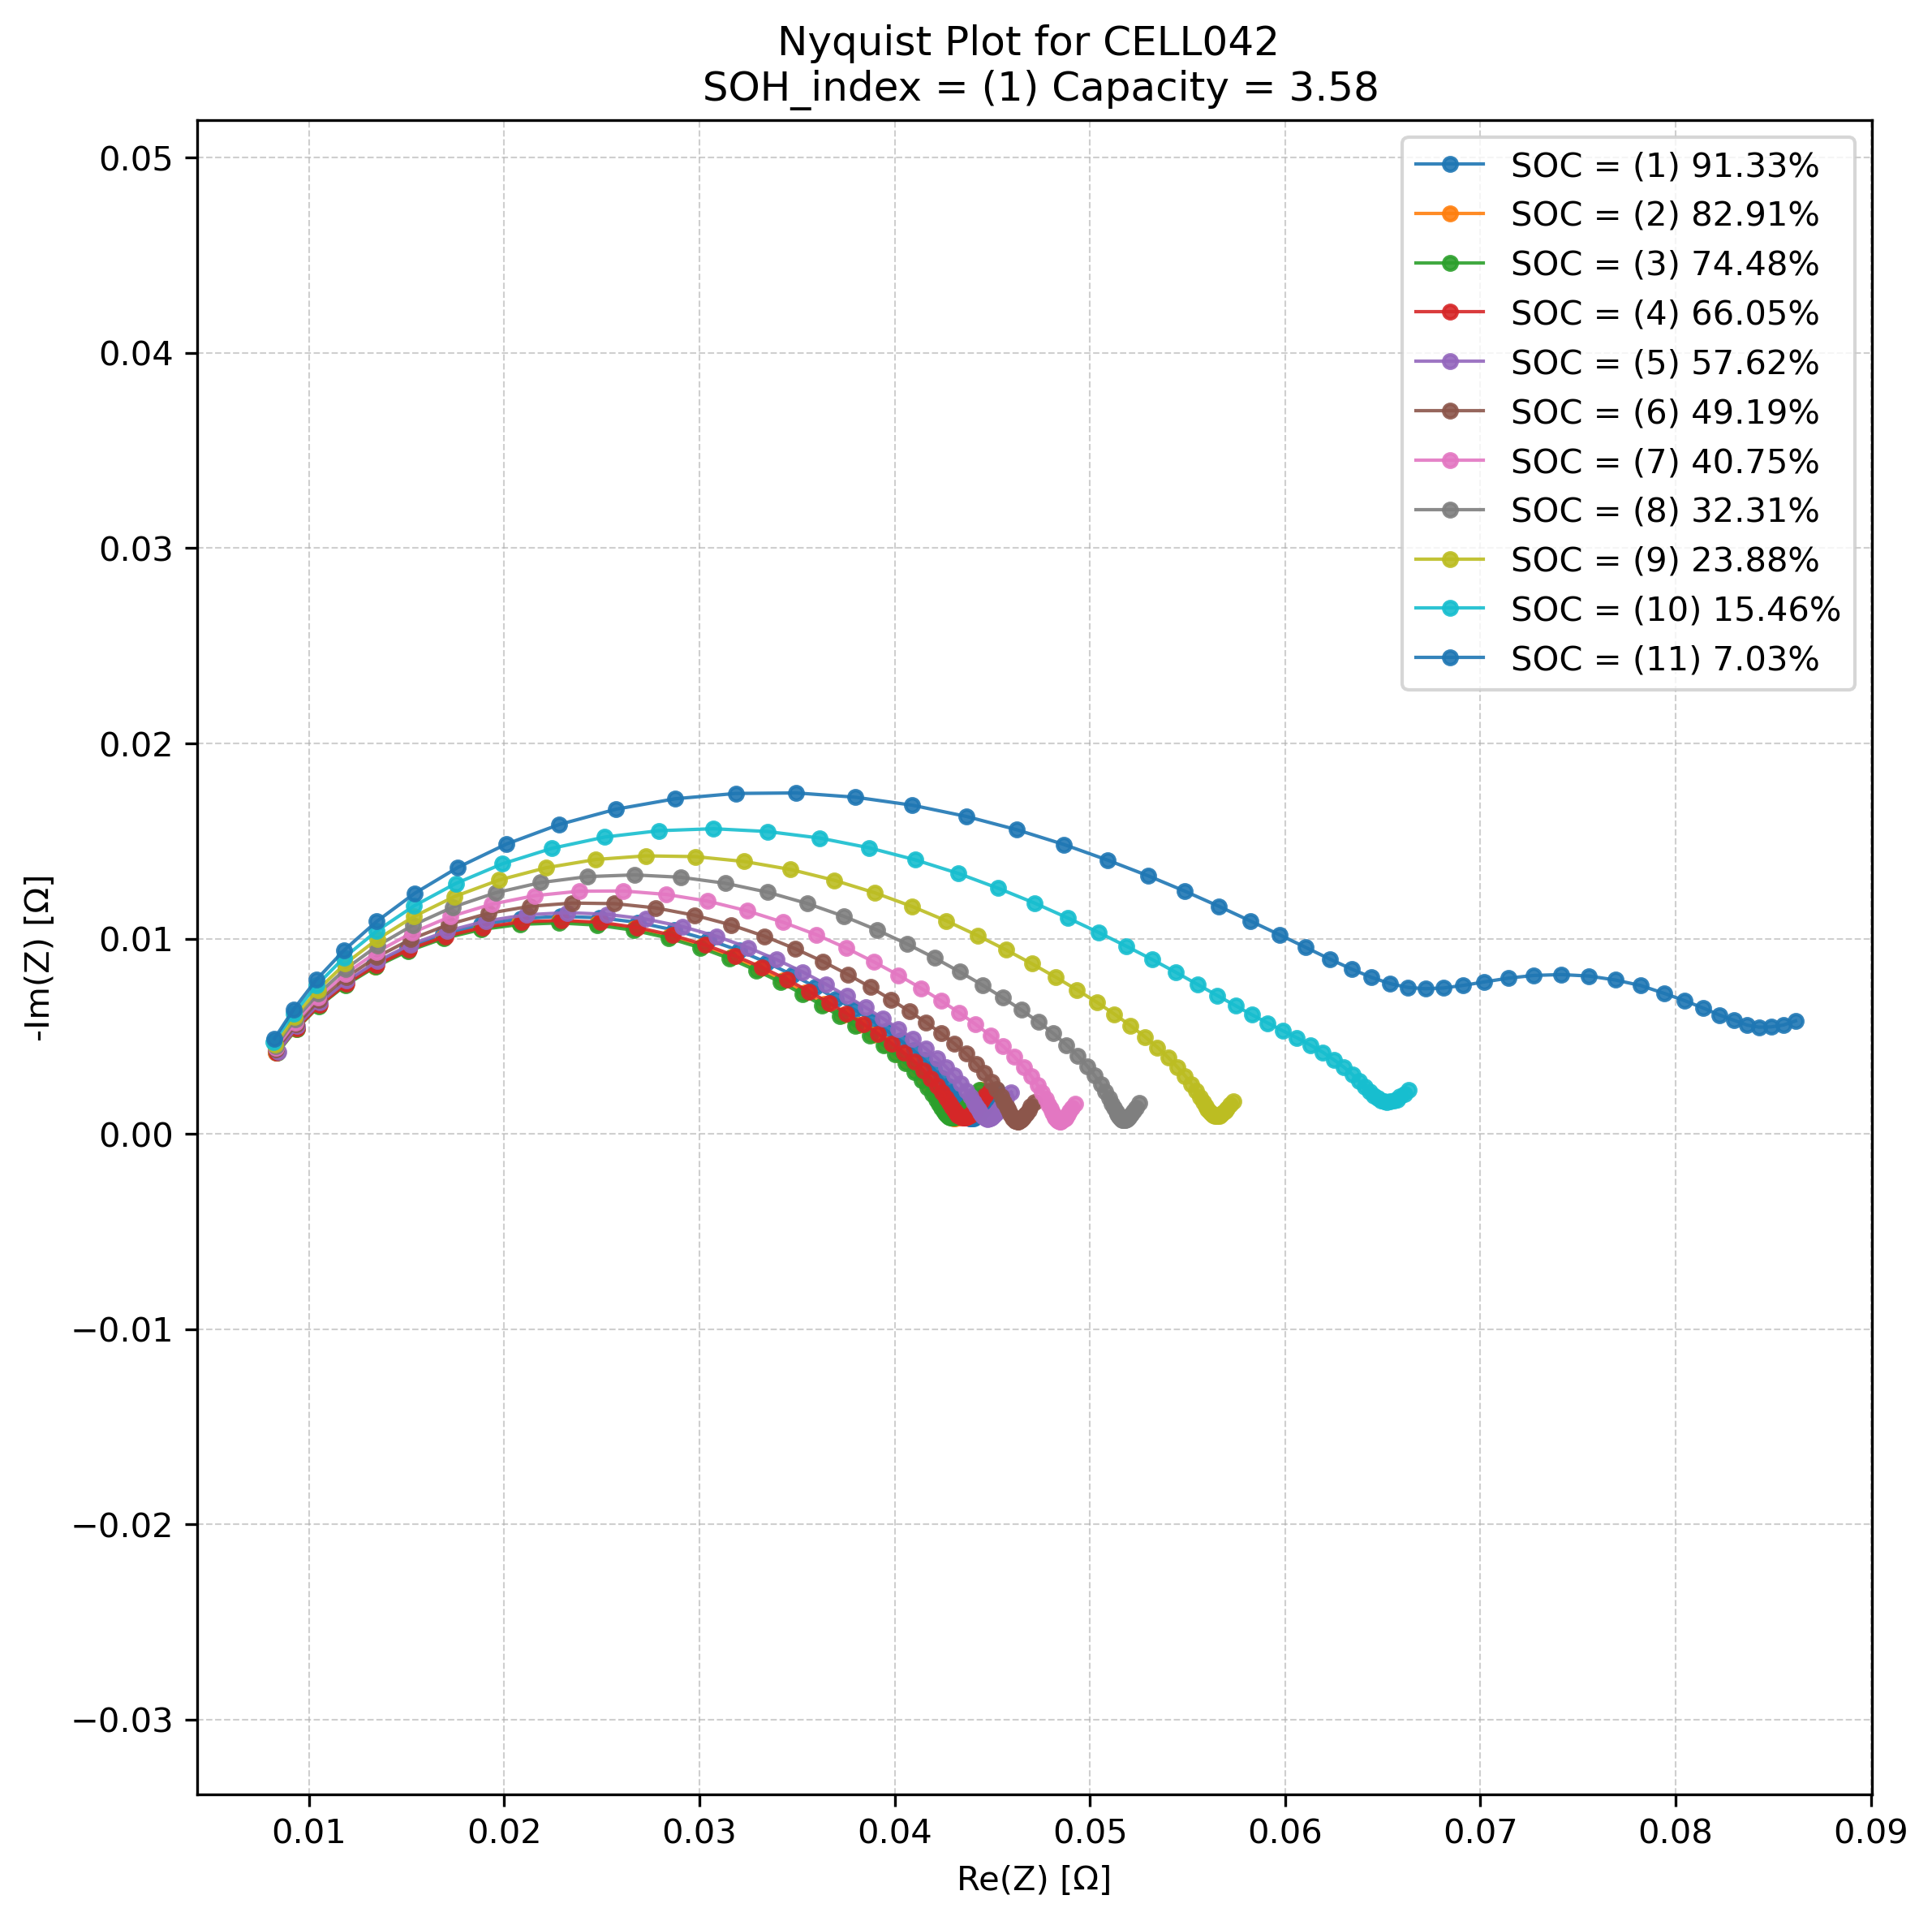

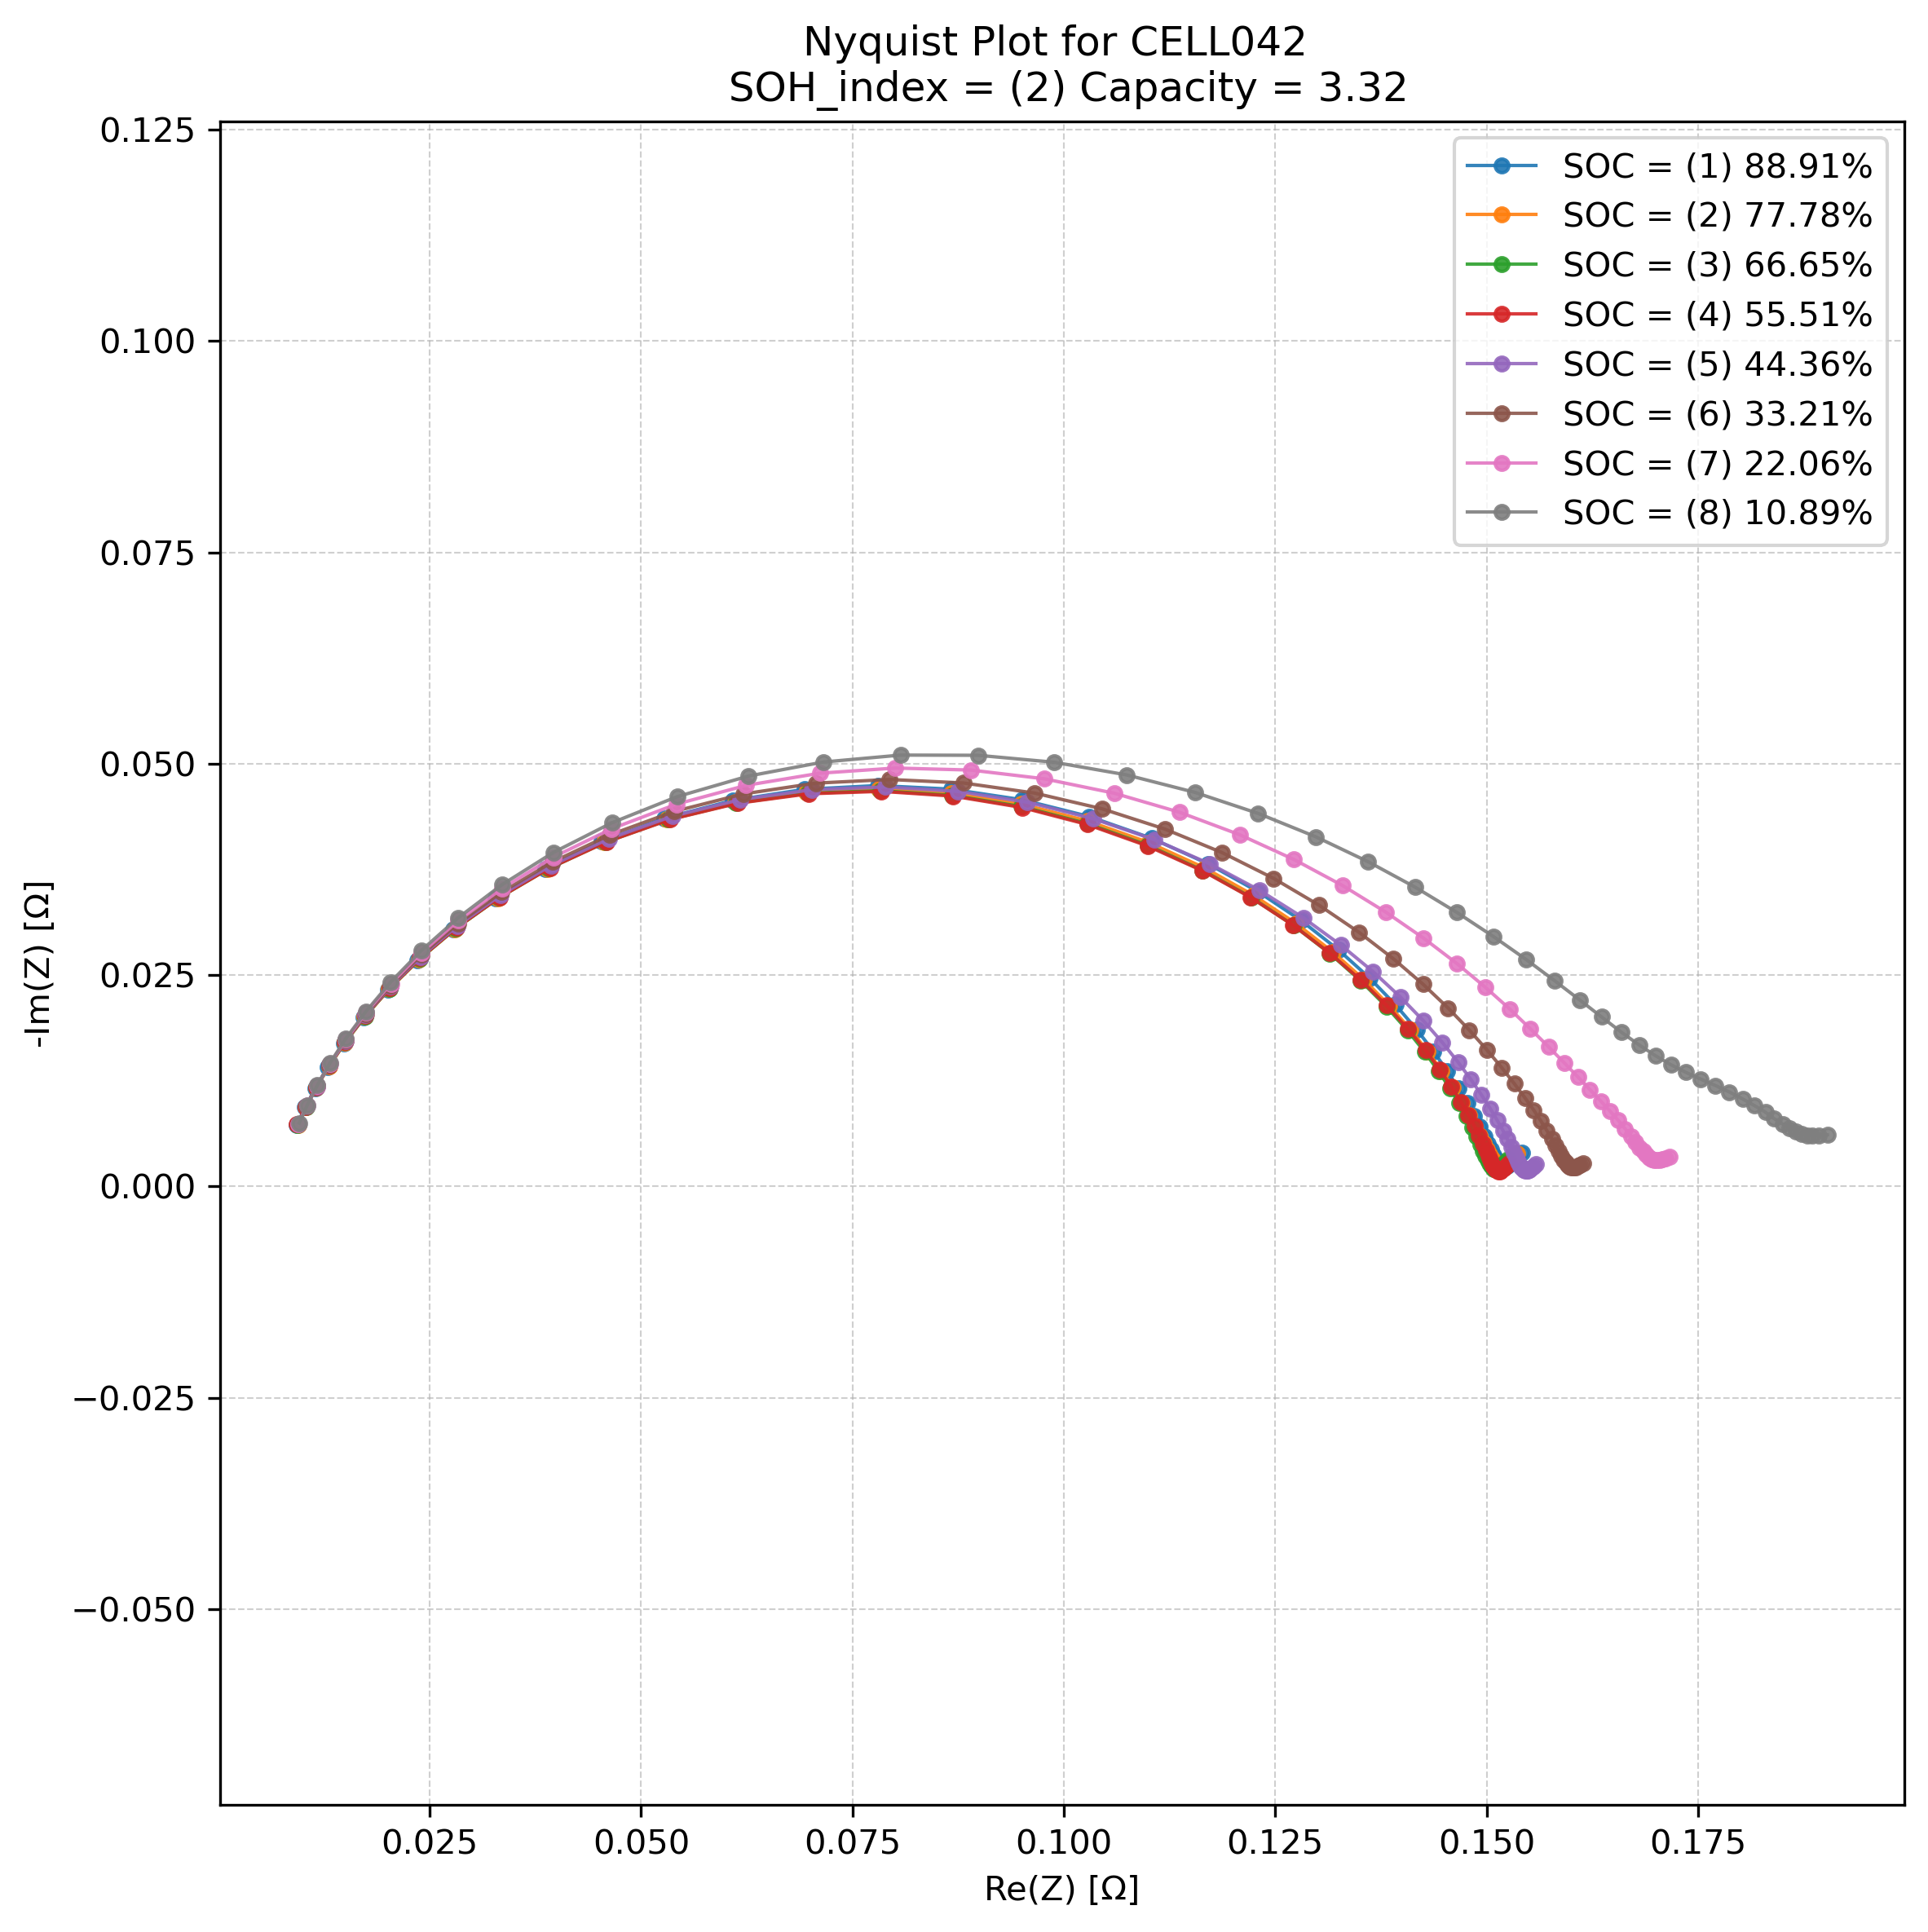

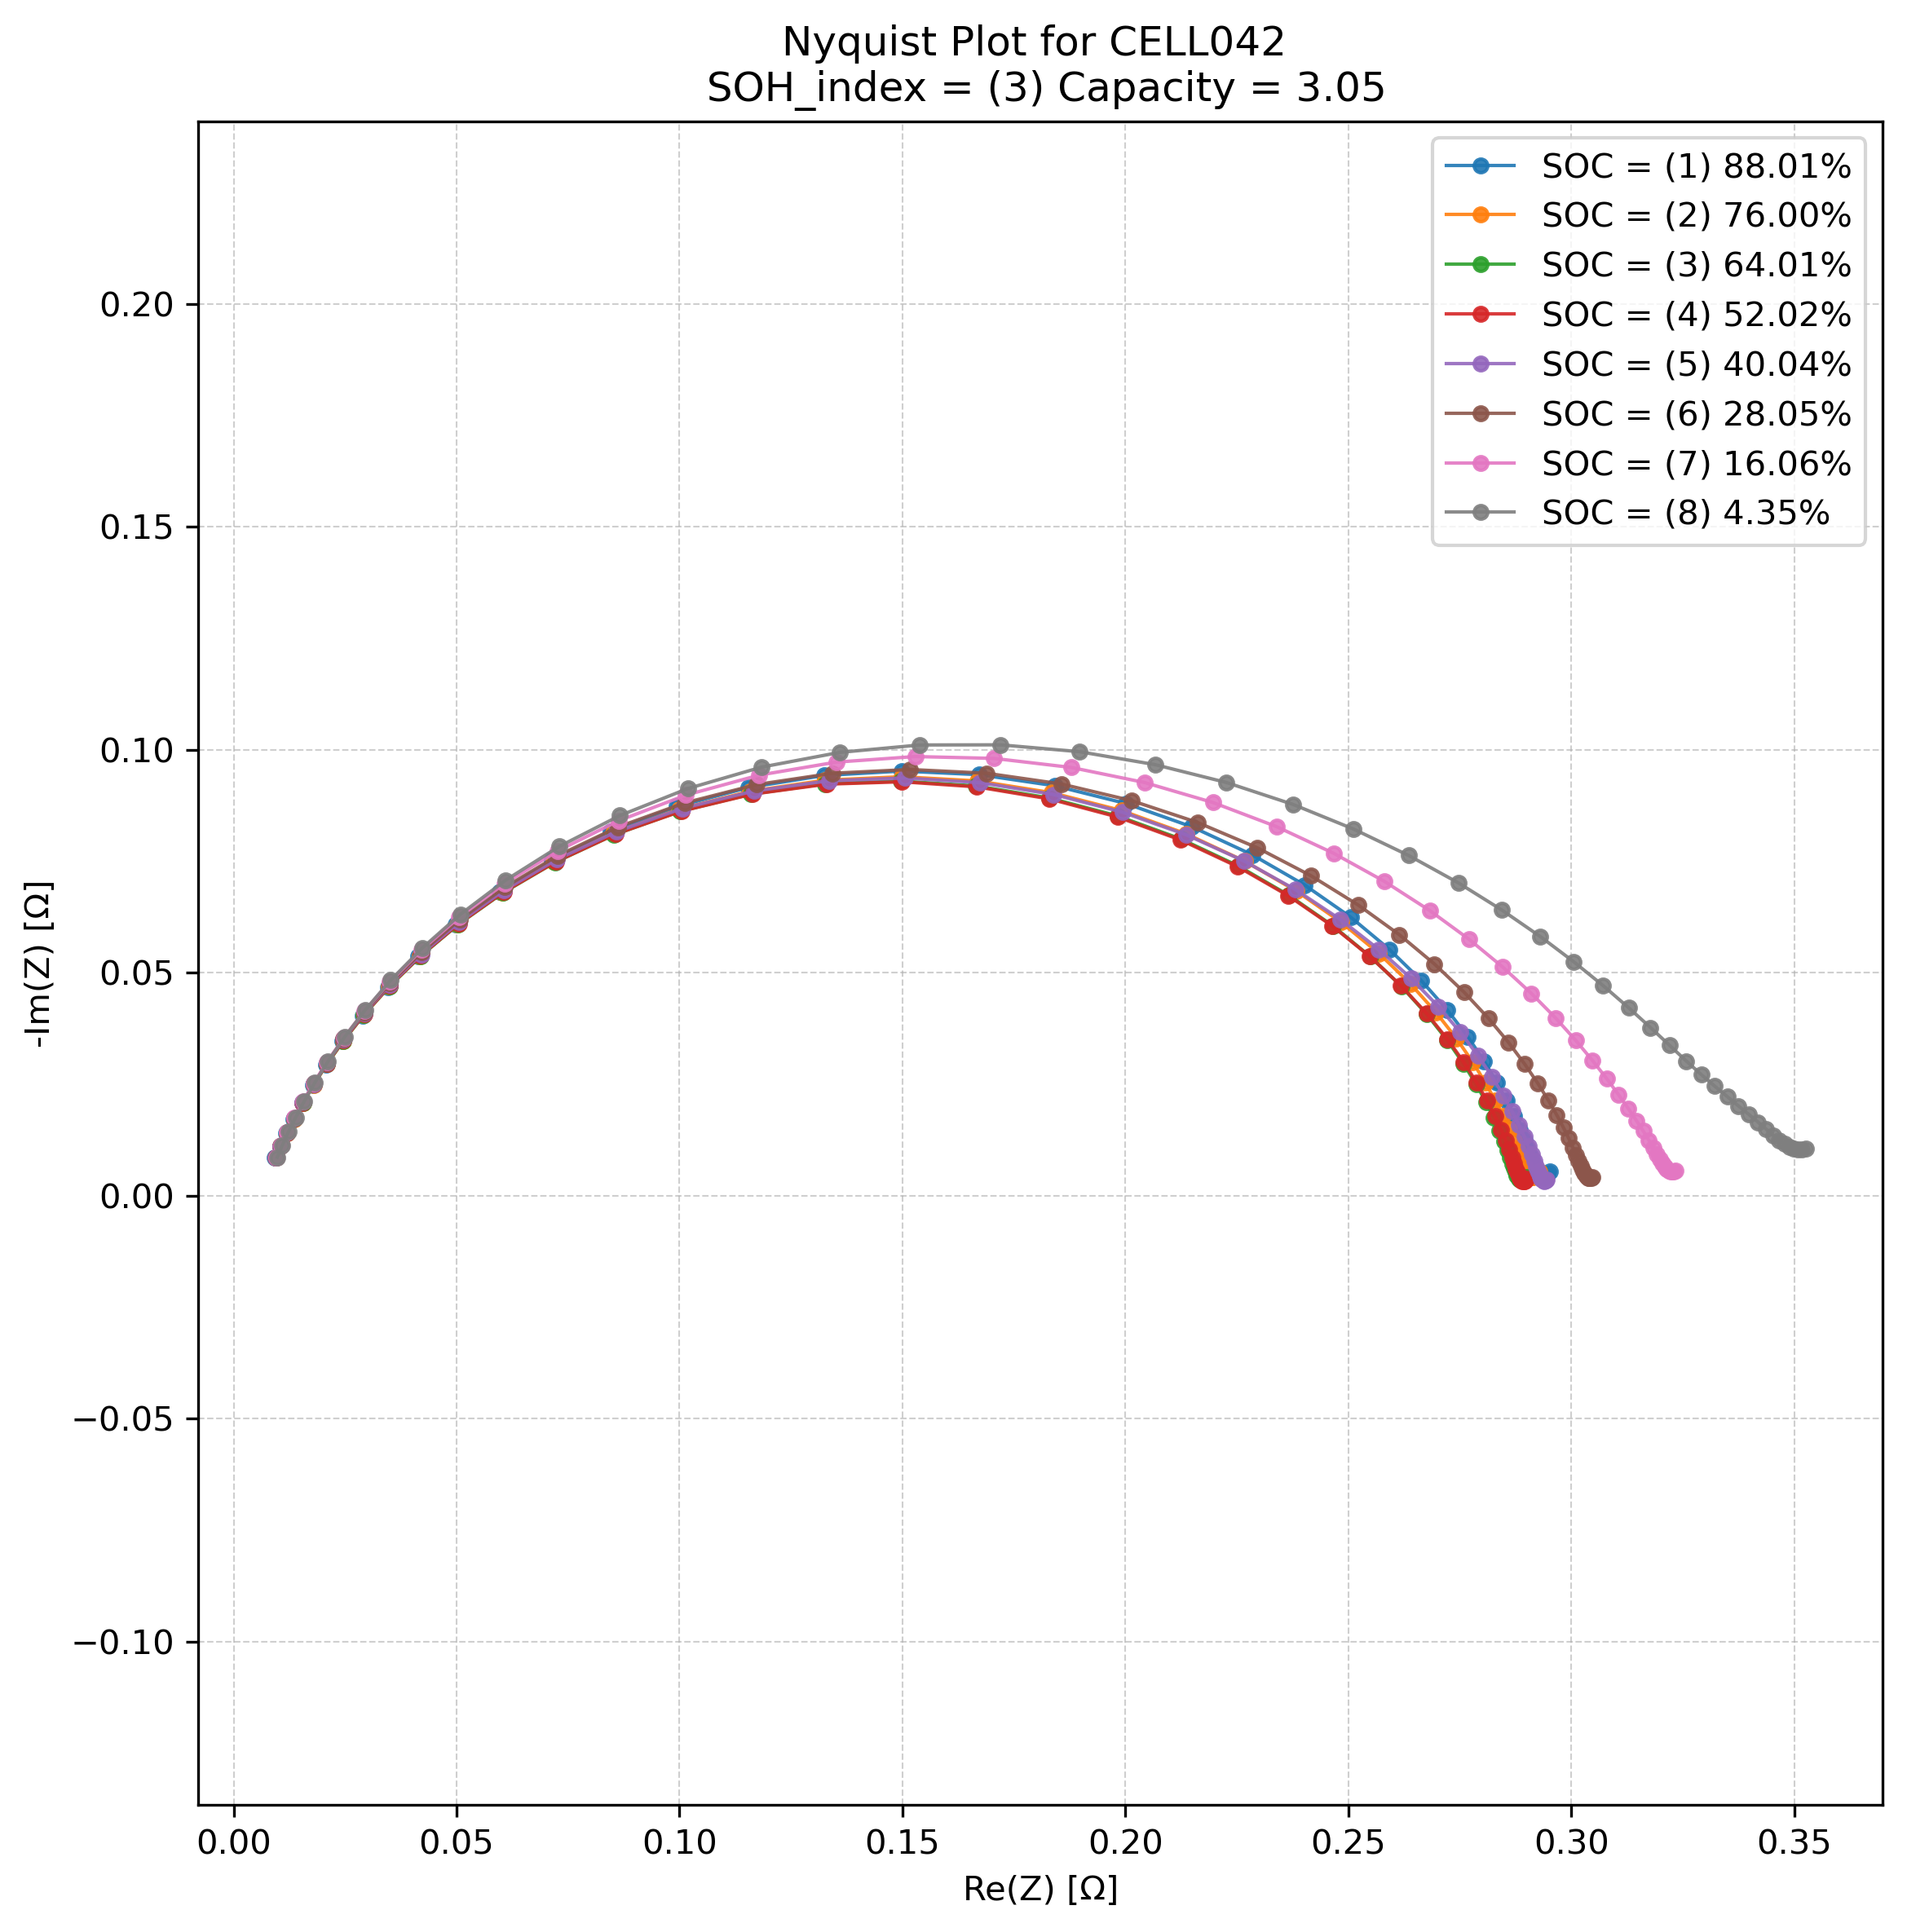

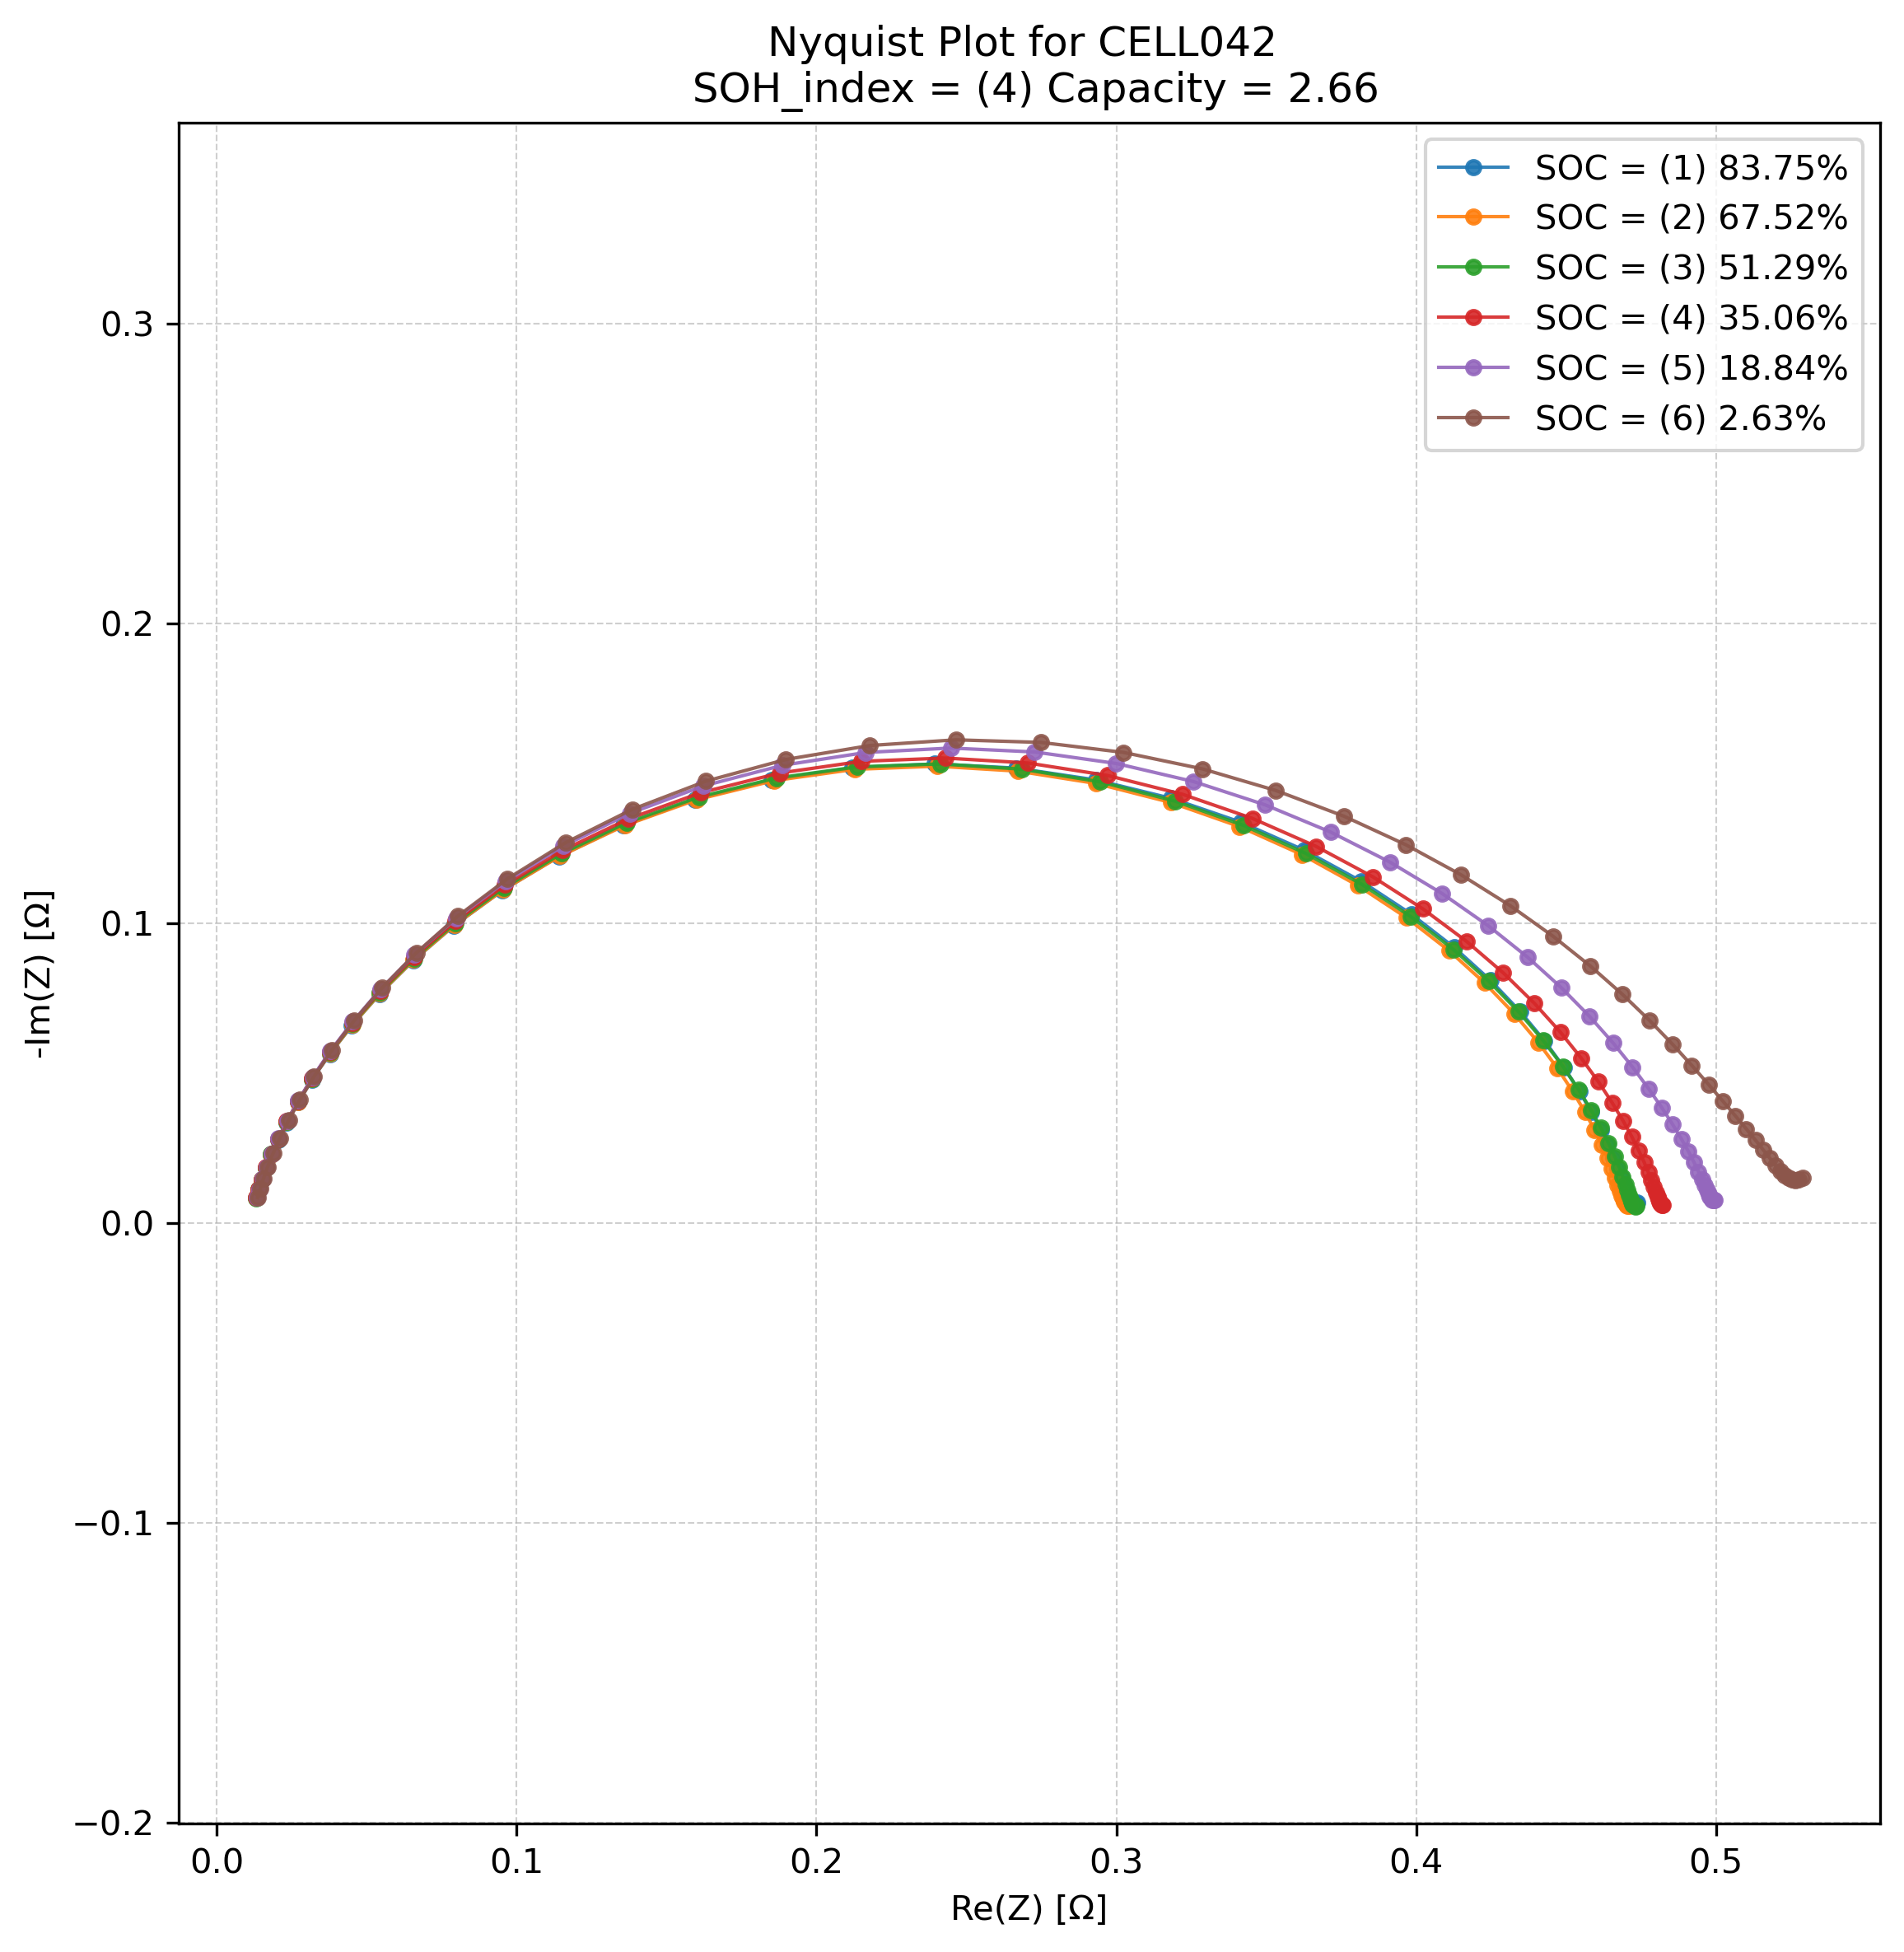

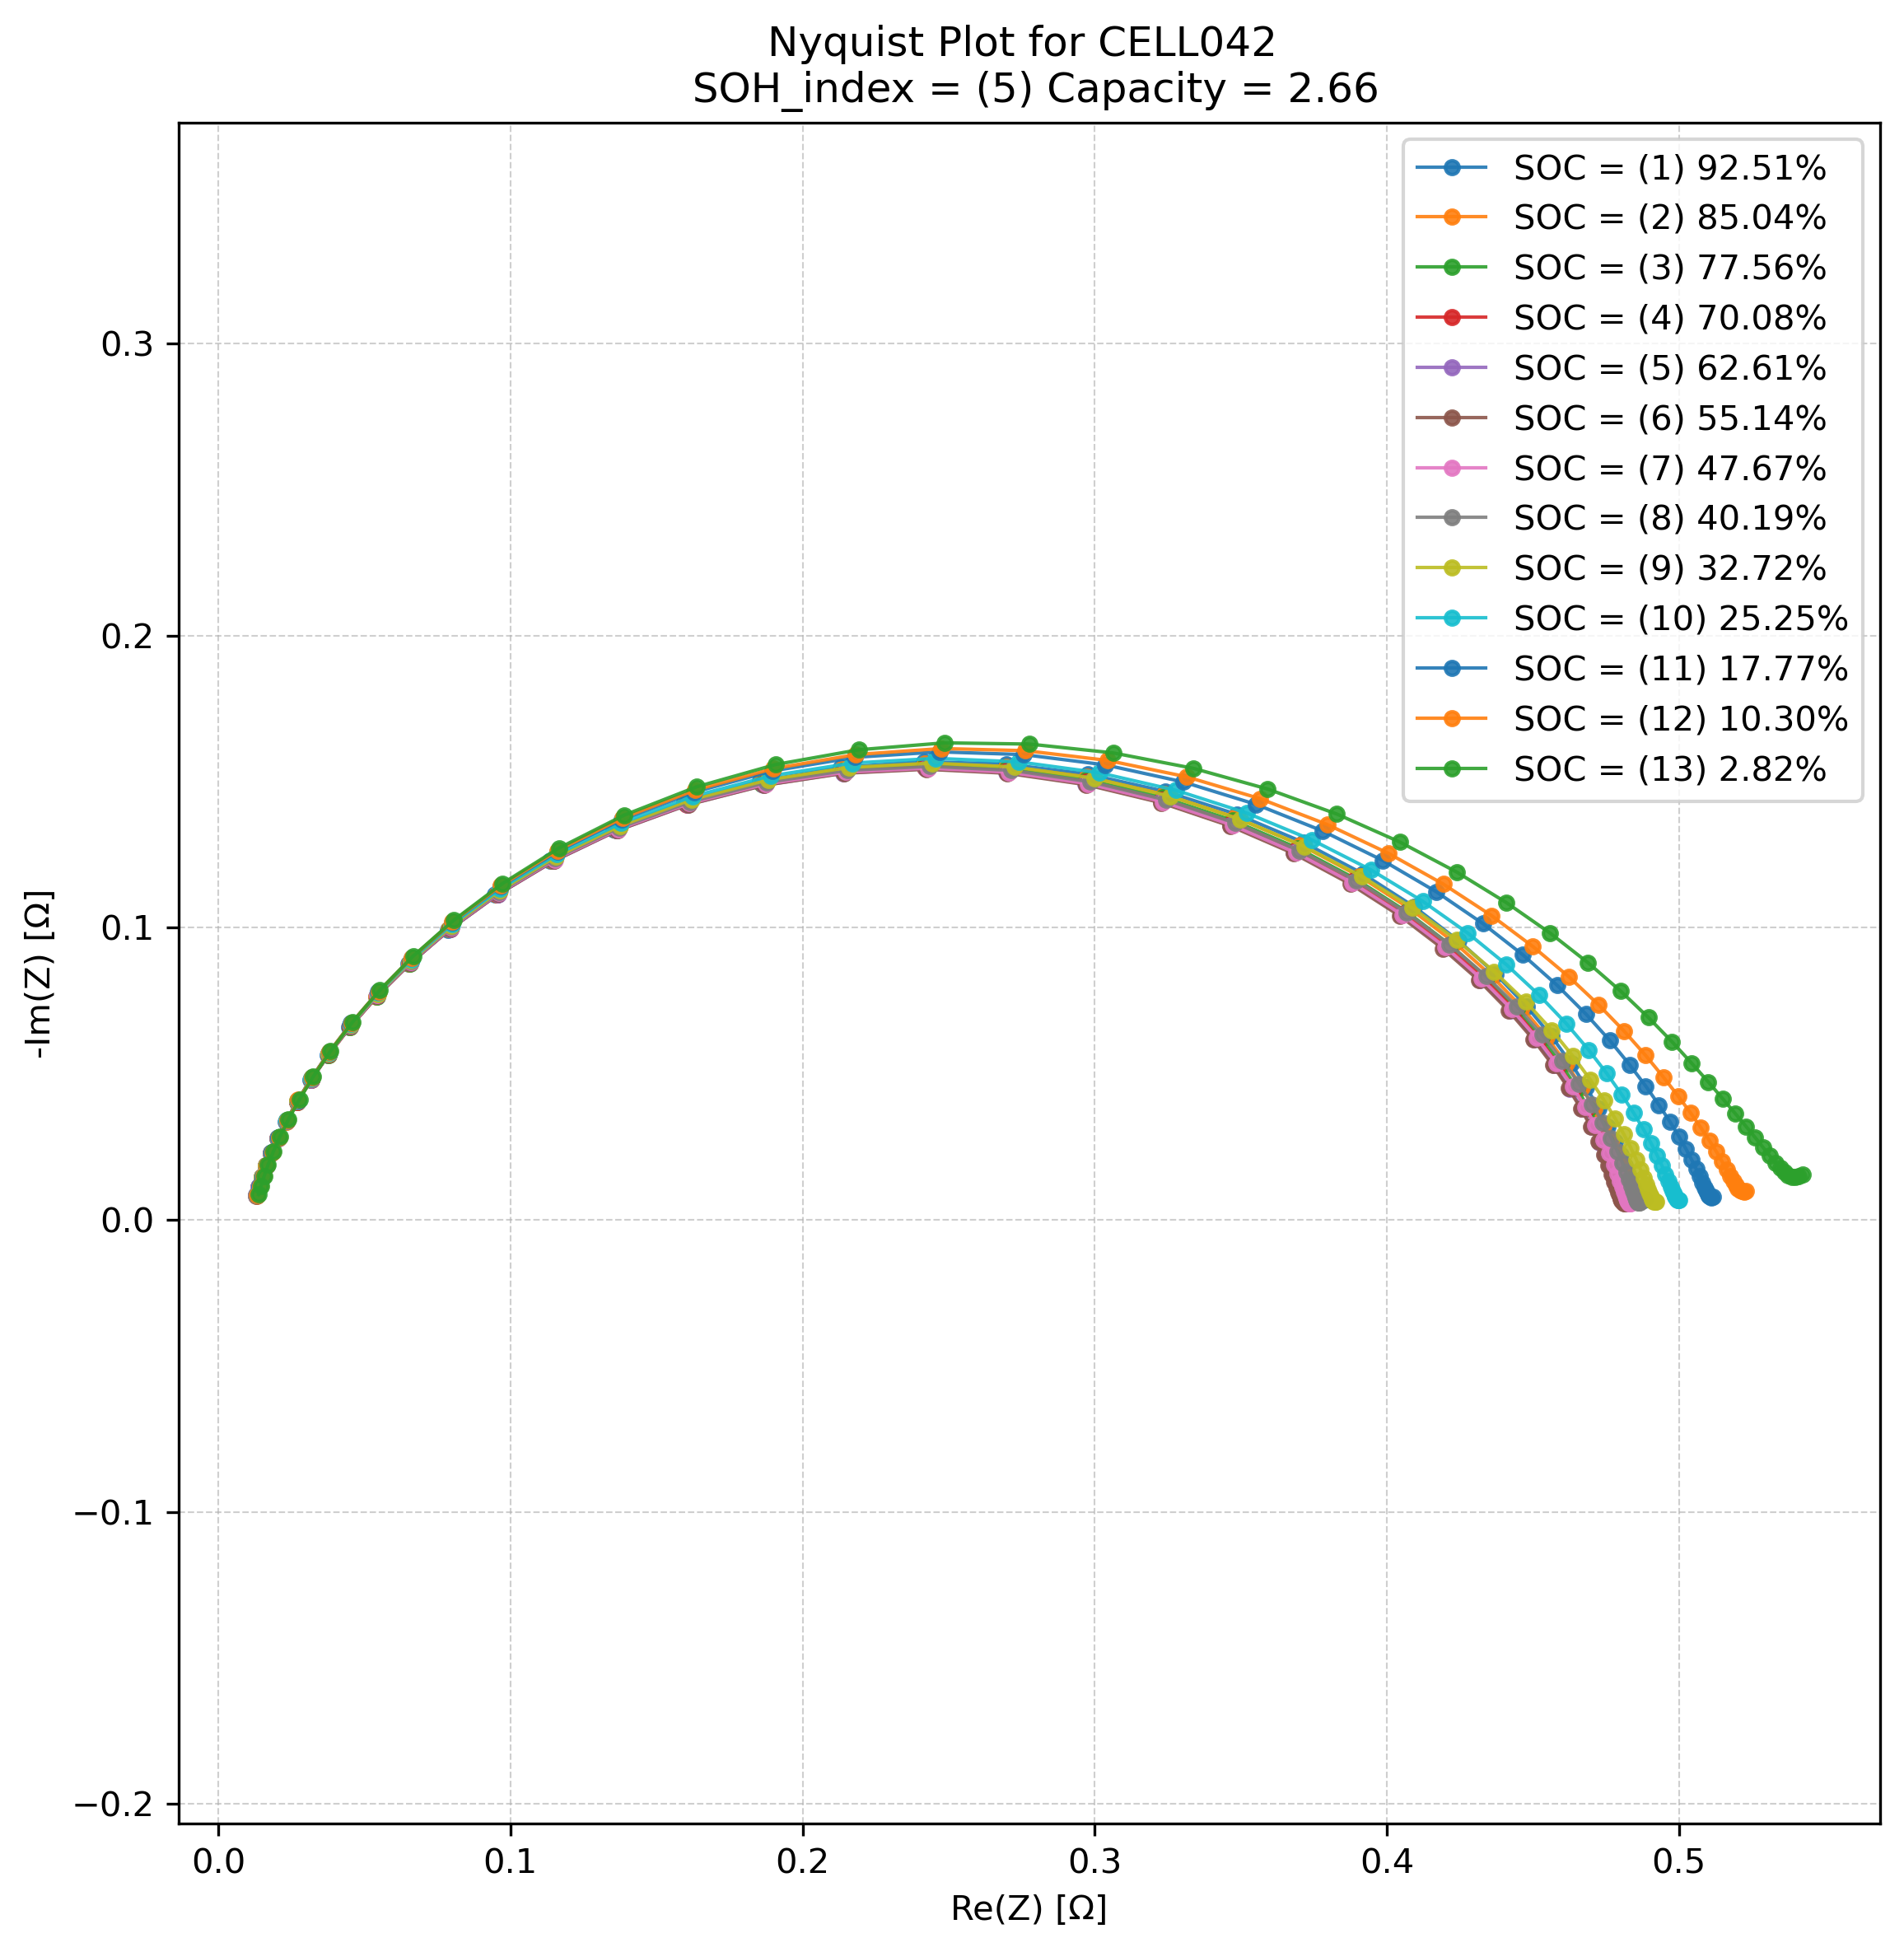

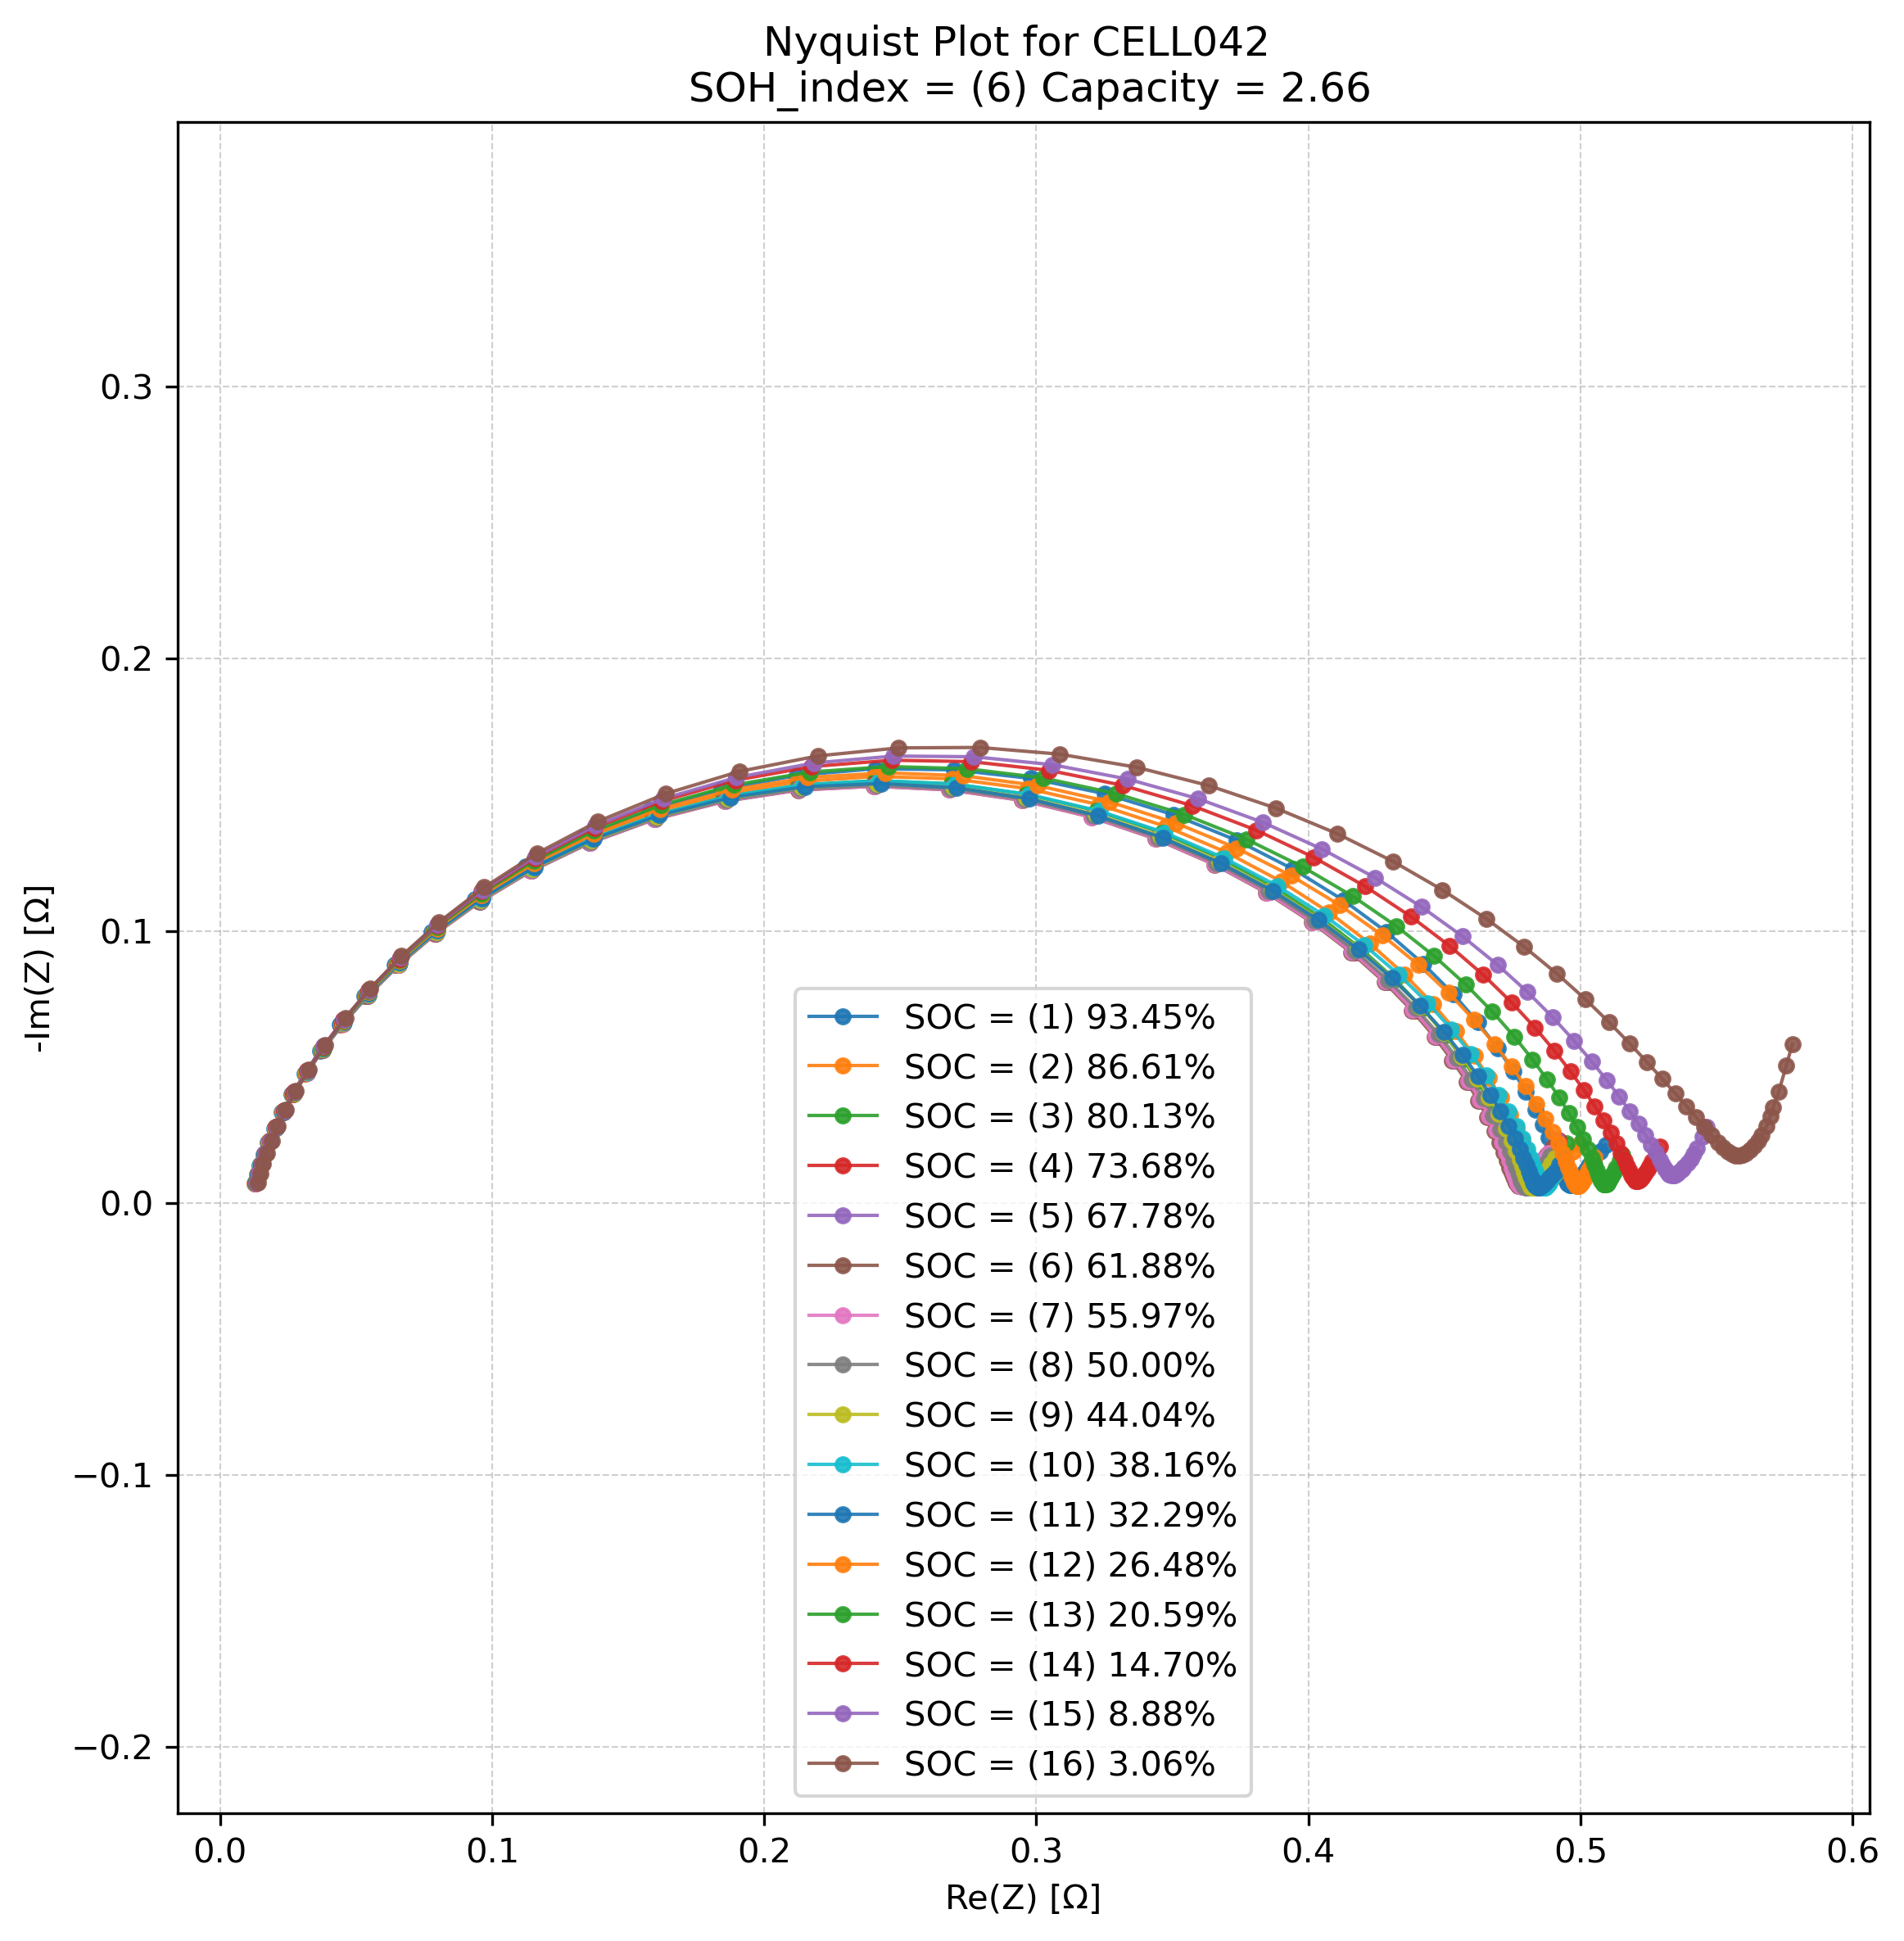

In [19]:
cell42_num_soh = cell42_metadata["num_soh"]

for soh_i in range(cell42_num_soh):
    num_soc = cell42_metadata["soh"][soh_i]["num_soc"]
    plot_input_list = [cell42_EISdata[soh_i][soc_i] for soc_i in range(num_soc)]
    plot_title = f"Nyquist Plot for CELL042 \n SOH_index = ({soh_i+1}) Capacity = {cell42_metadata["soh"][soh_i]["capacity"]:.2f}"
    labels = [f"SOC = ({soc_i+1}) {cell42_metadata["soh"][soh_i]["soc"][soc_i]*100:.2f}%" for soc_i in range(num_soc)]
    fig, ax = plot_EIS_Nyquist_multi(plot_input_list, labels, title=plot_title)
    plt.show()
        

#### ECM Fitting Algo

In [ ]:
ECM_parameter_estimation("v3CM9", "CELL042", cell42_metadata, cell42_EISdata, cost_func_name="RMSE_abs", trial_number=50)

#### Best Estimation Per Parameter Analysis

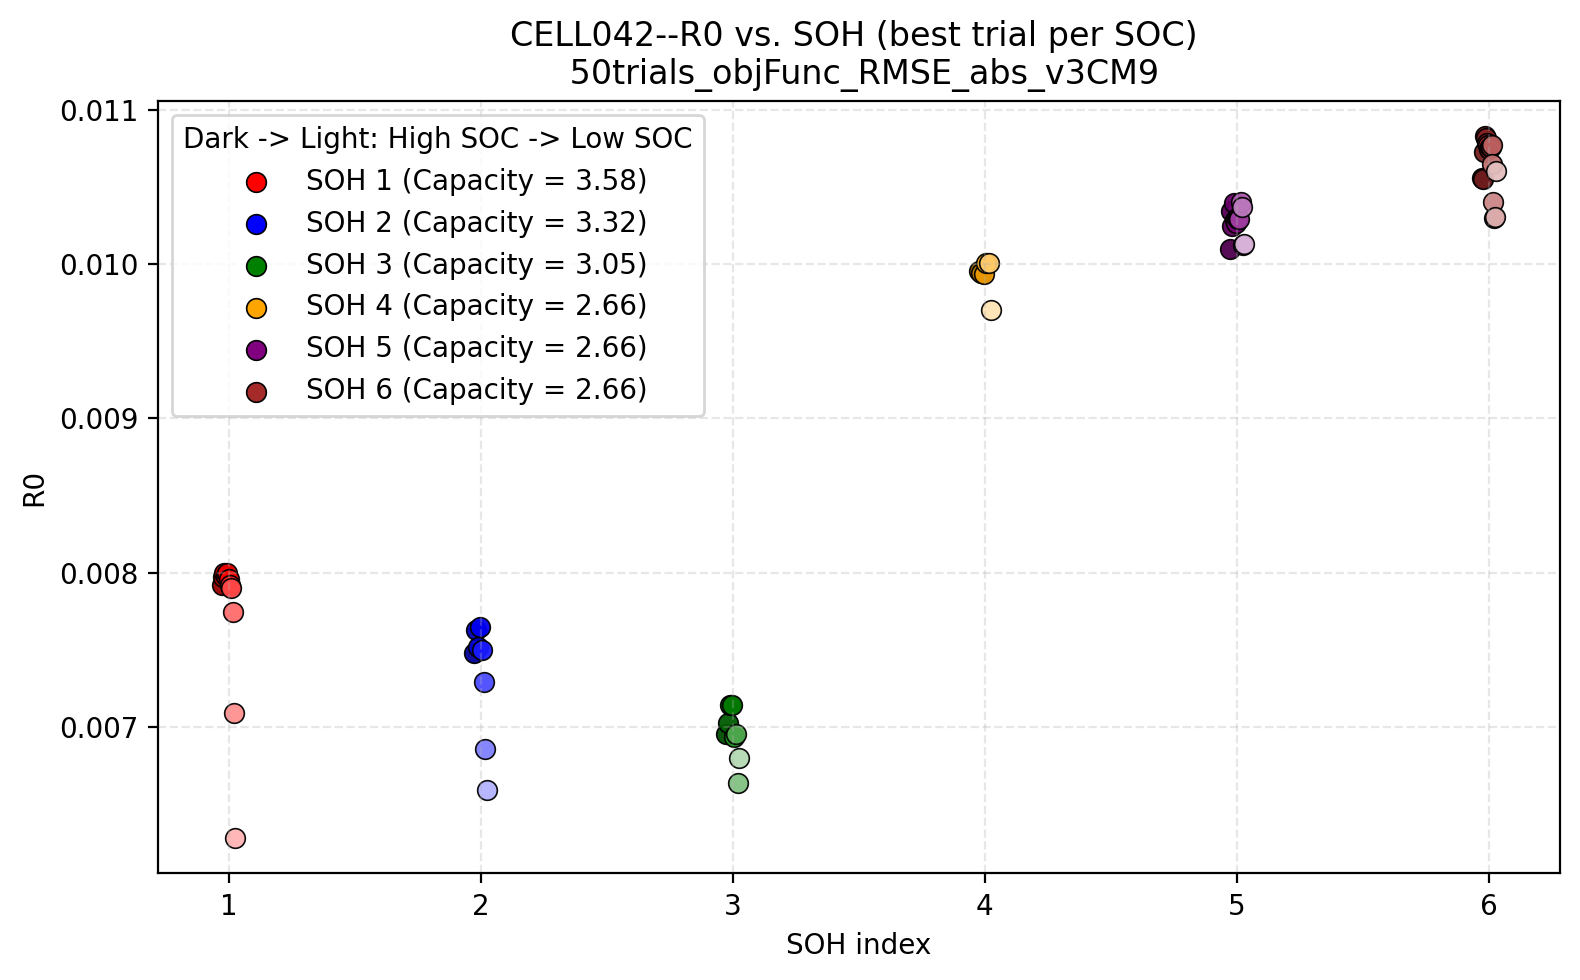

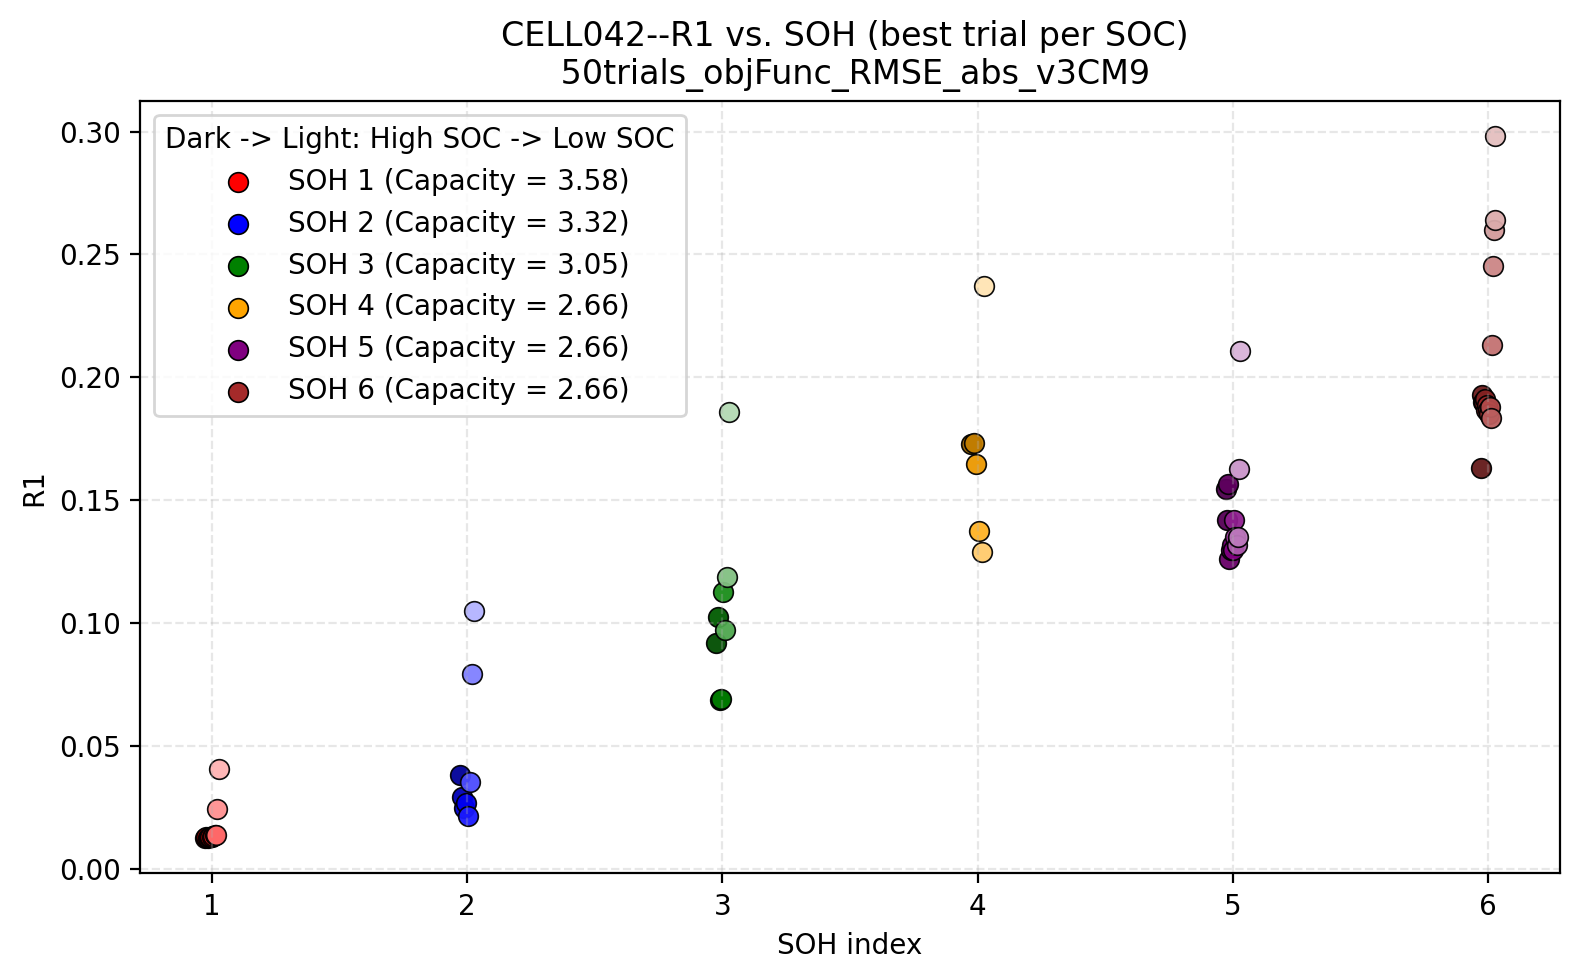

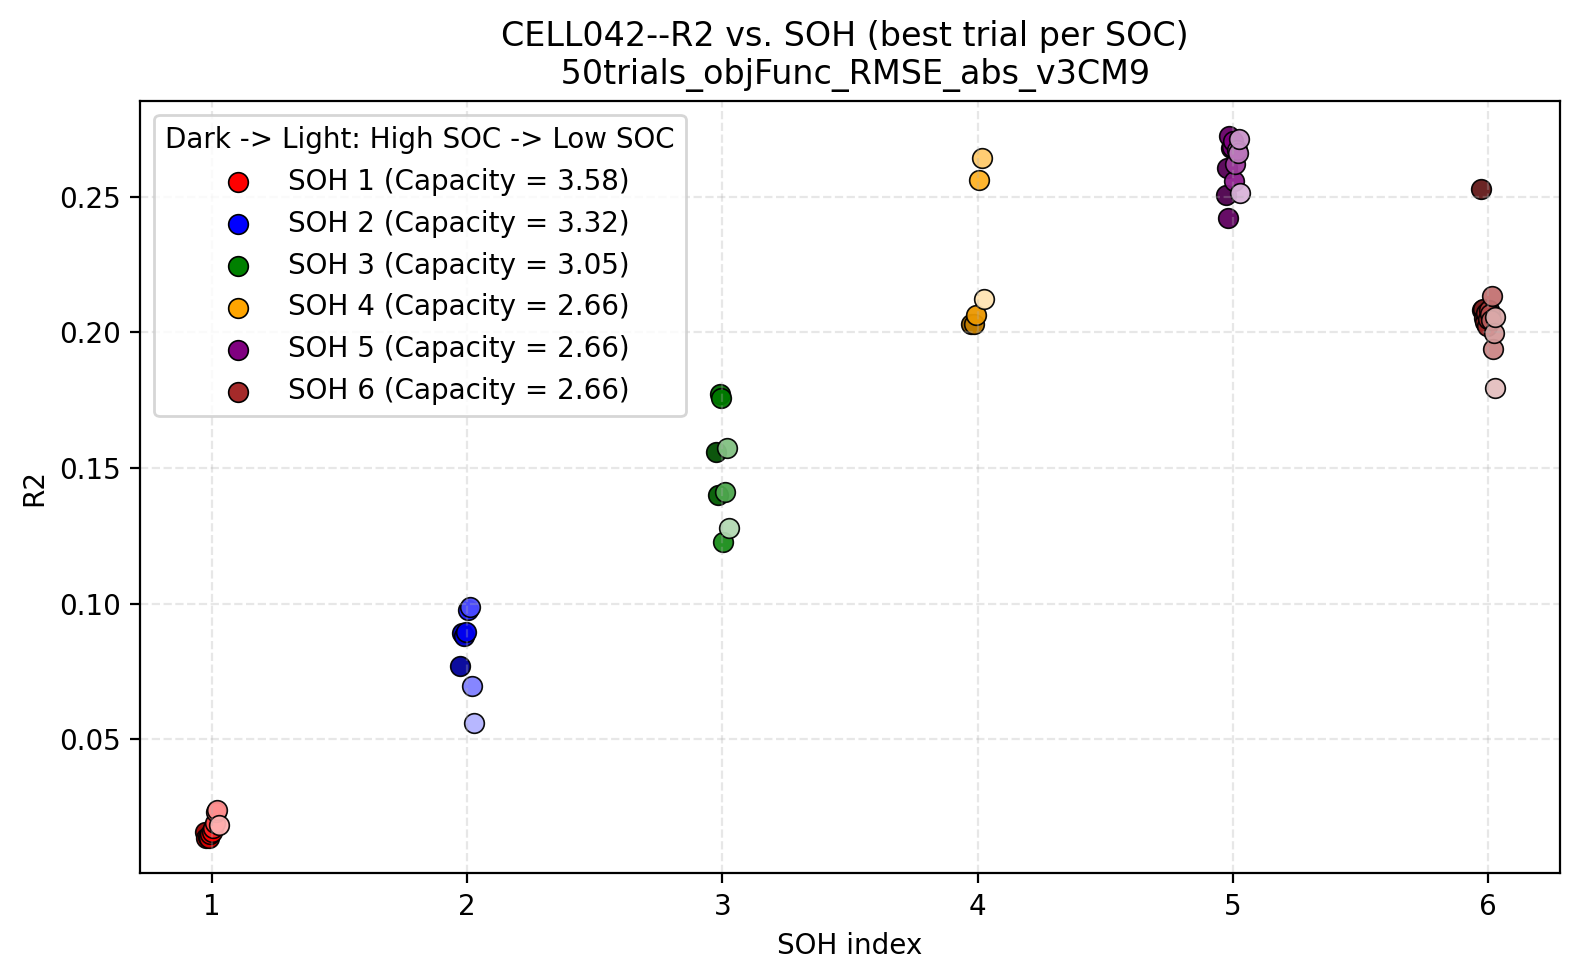

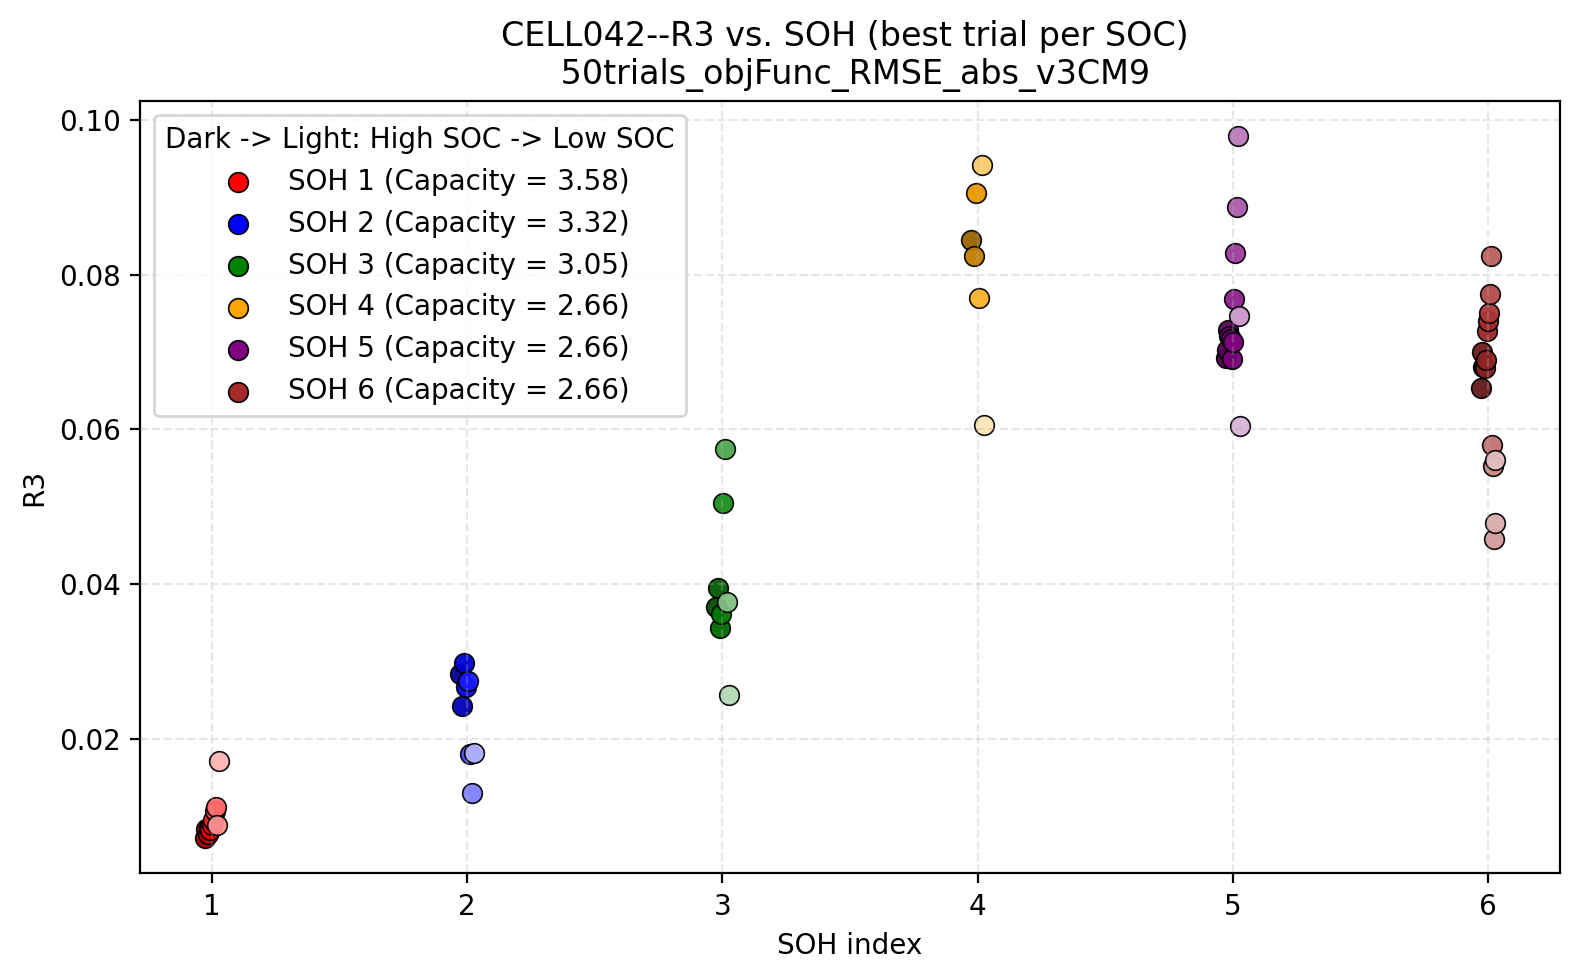

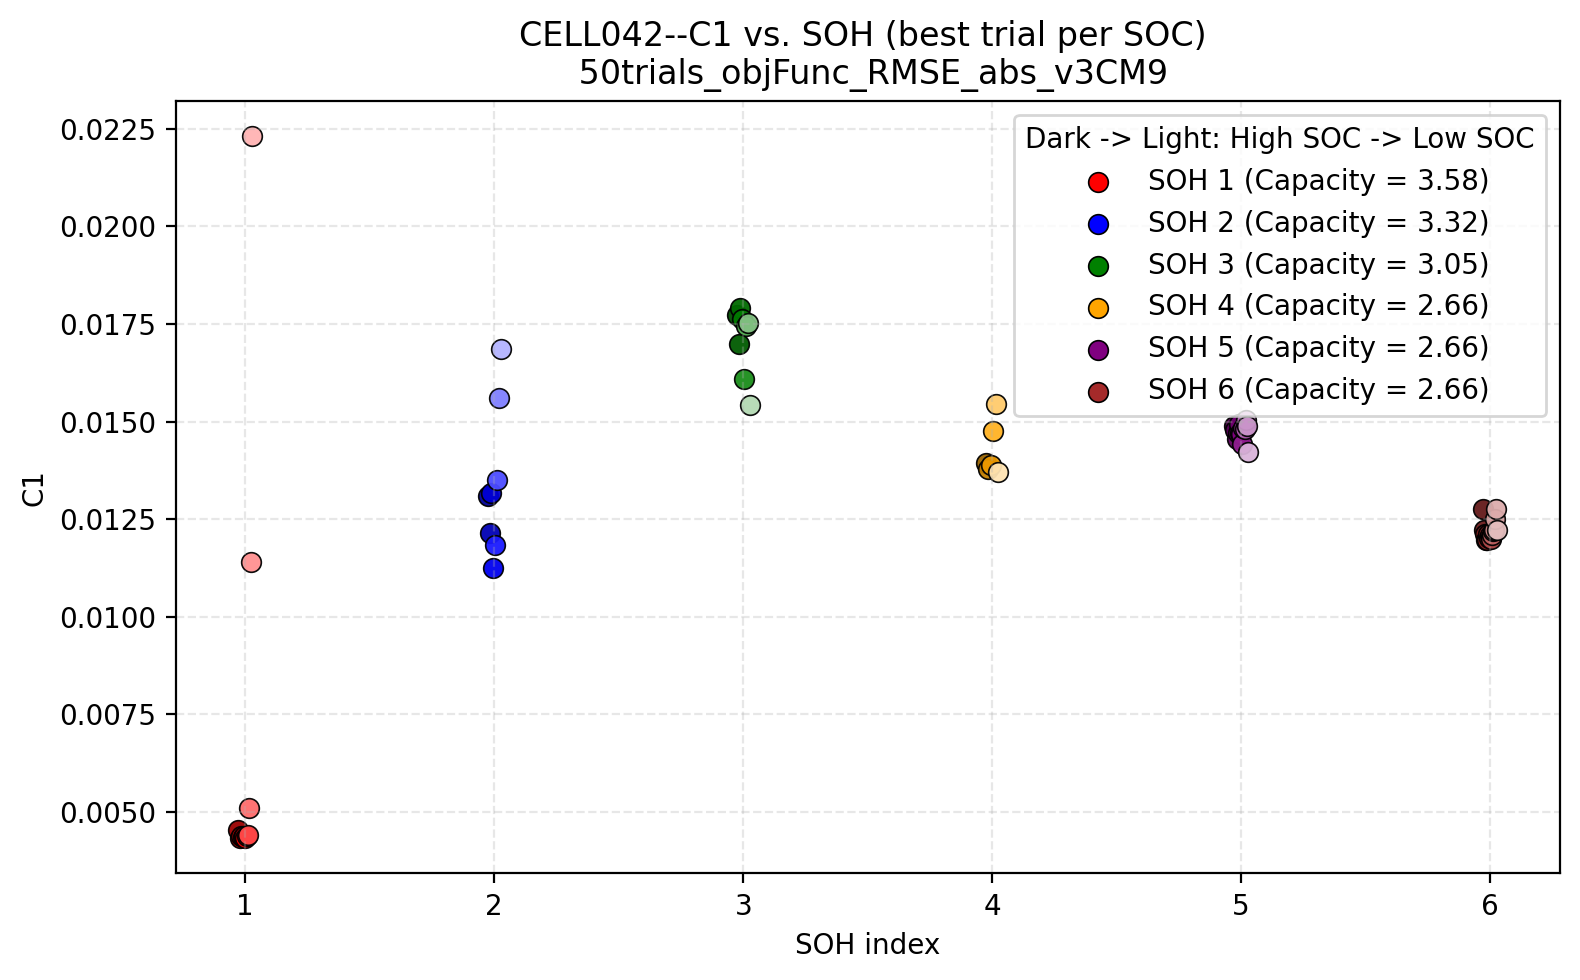

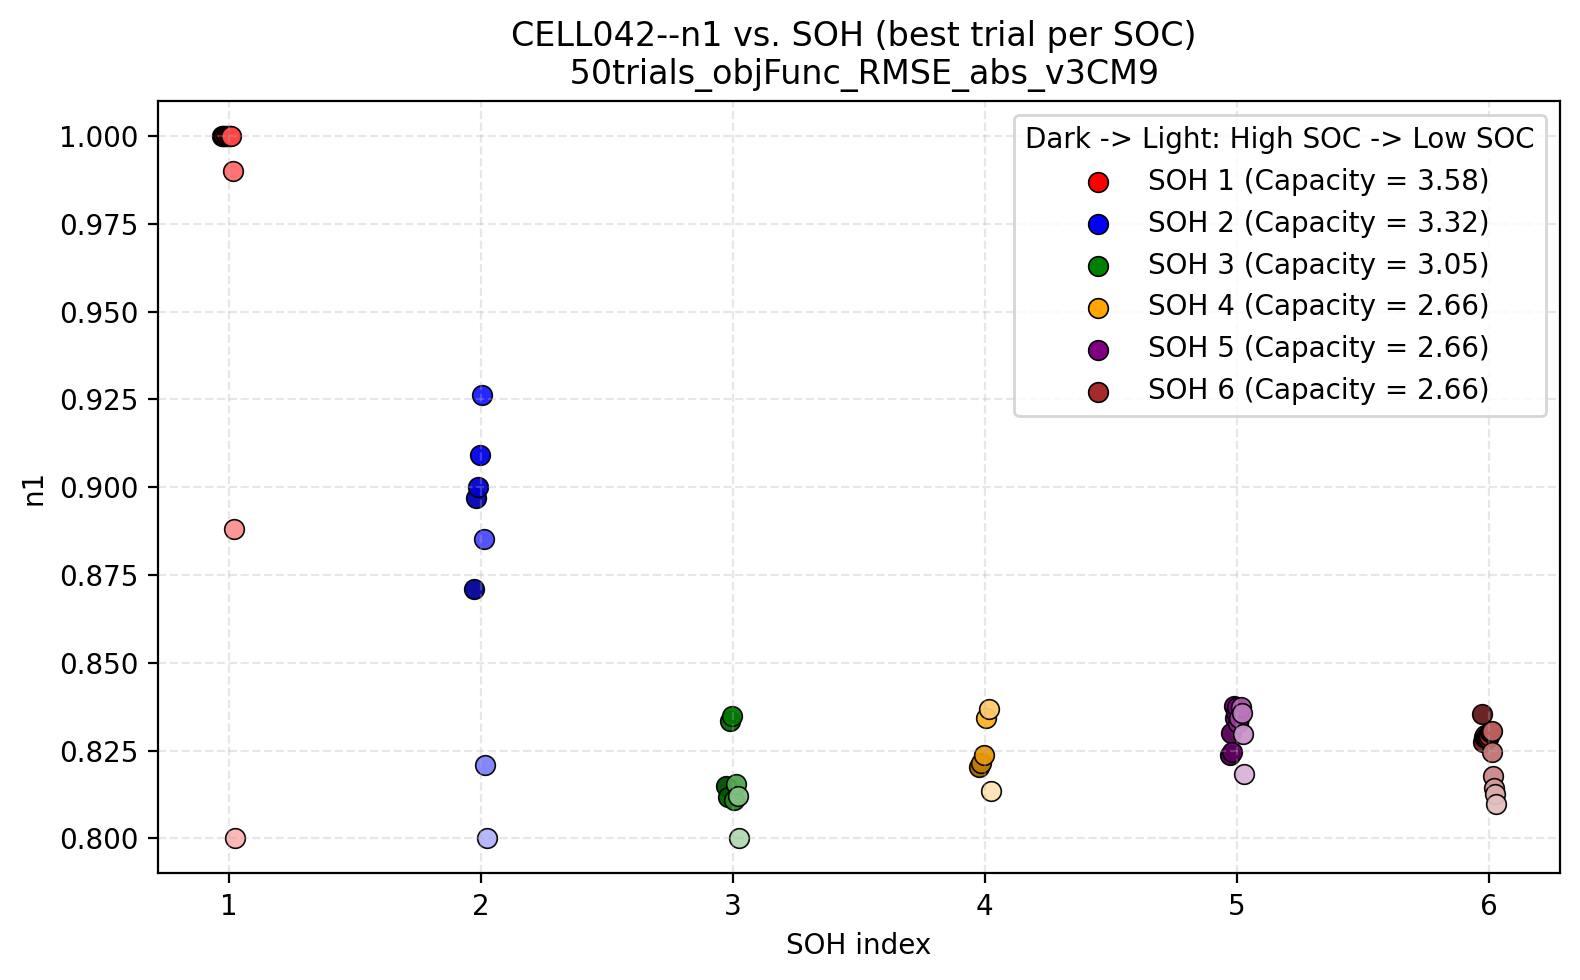

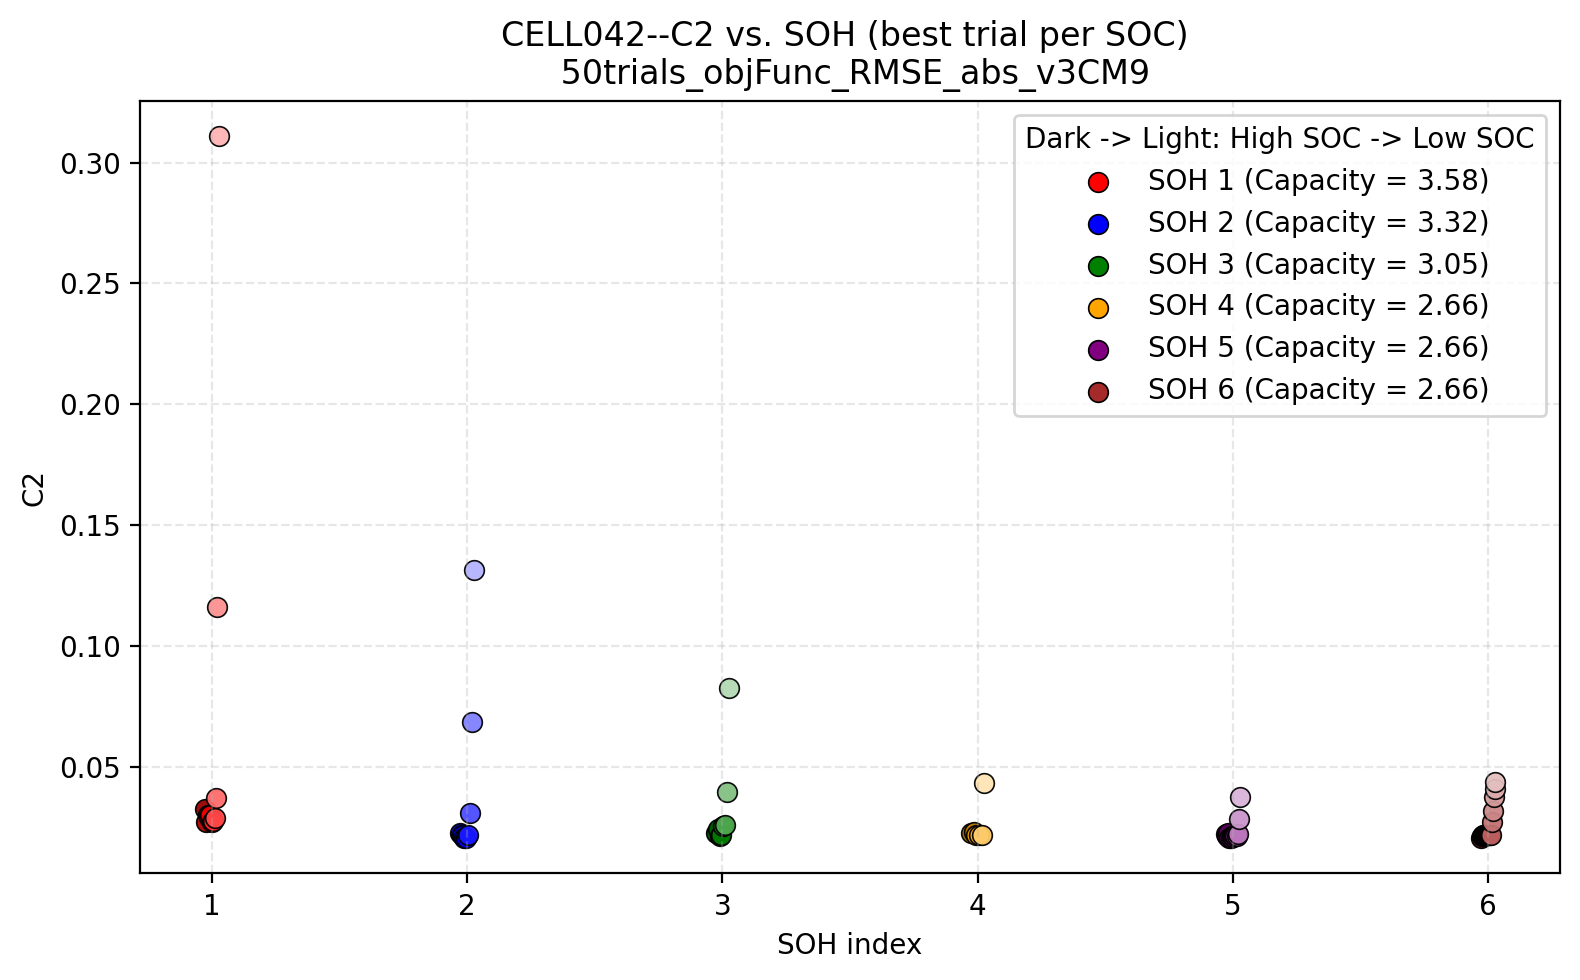

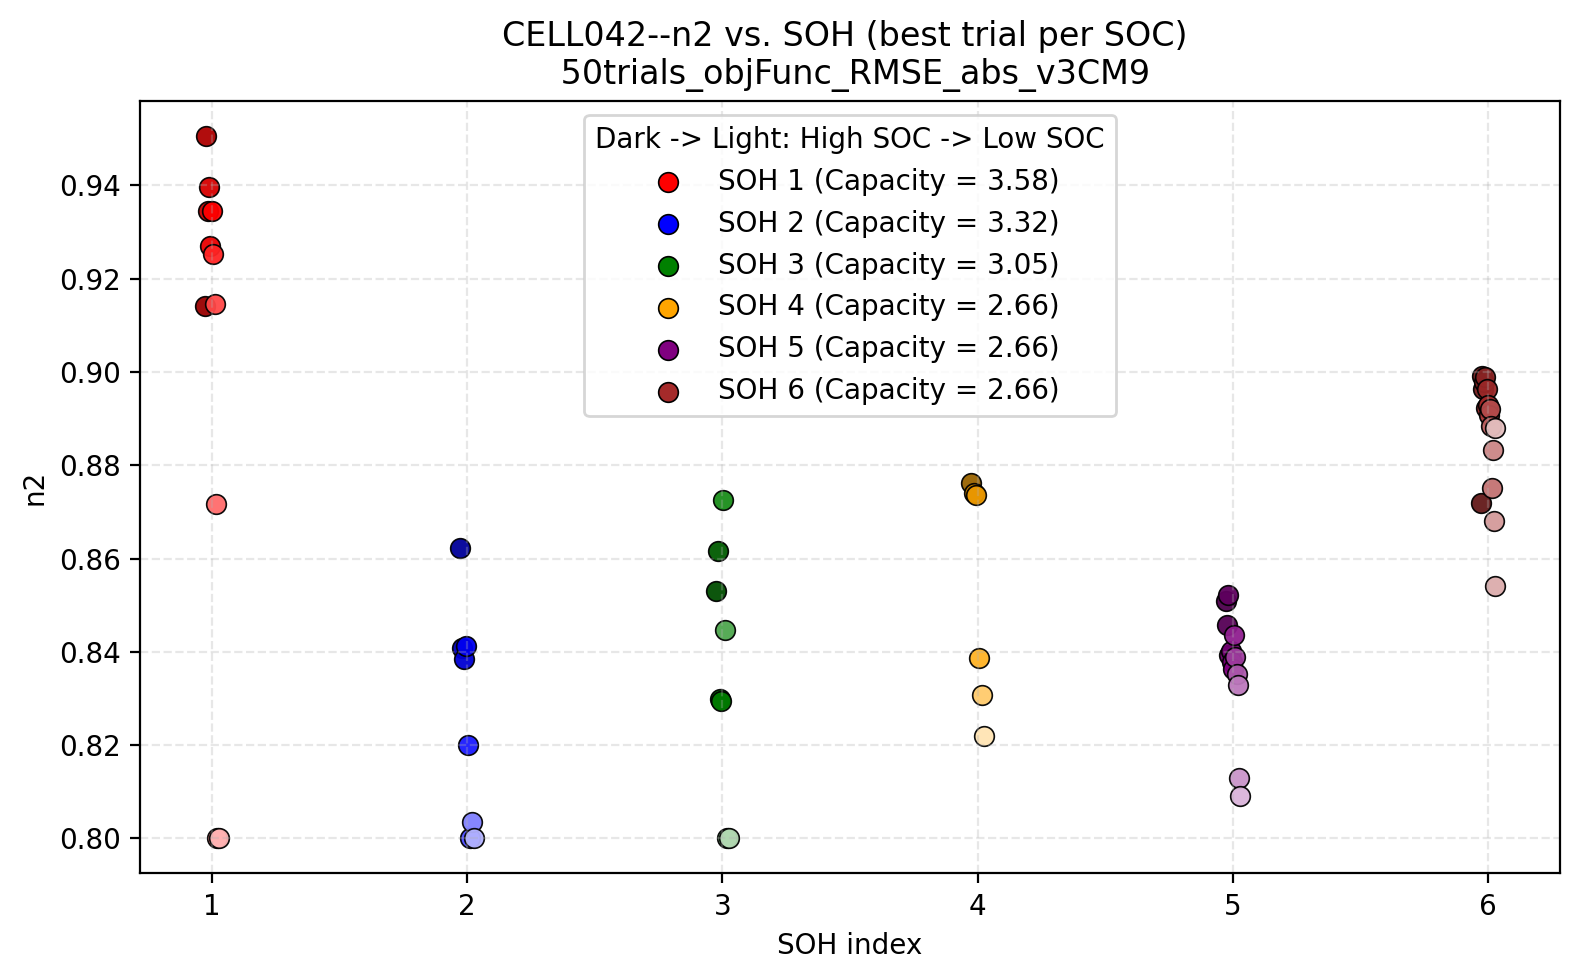

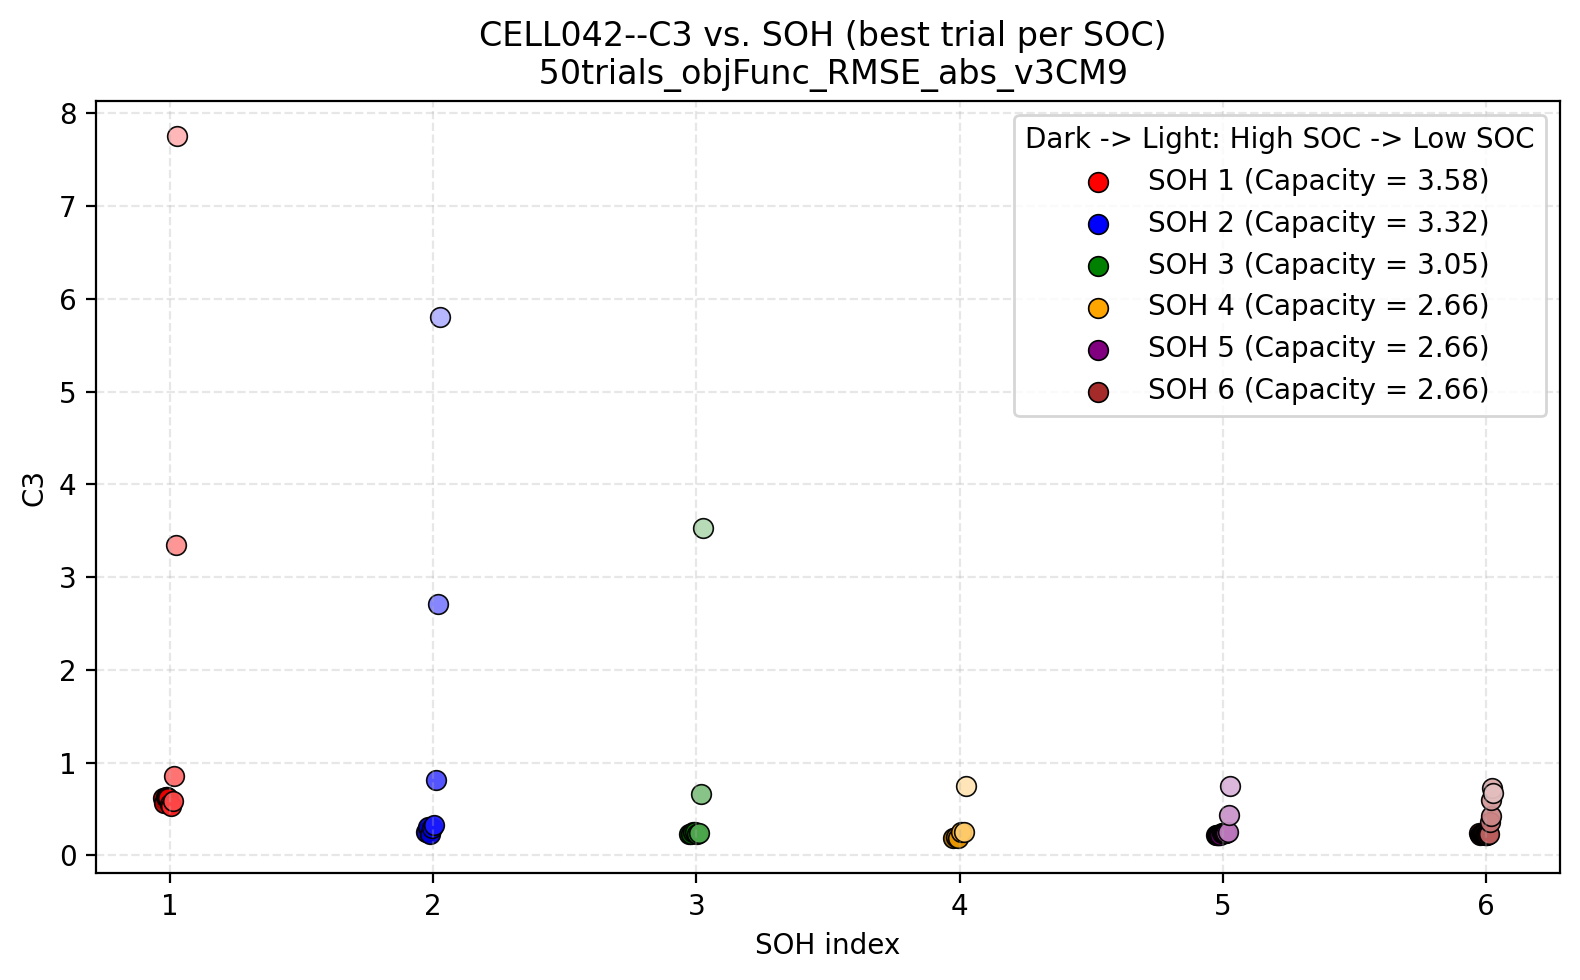

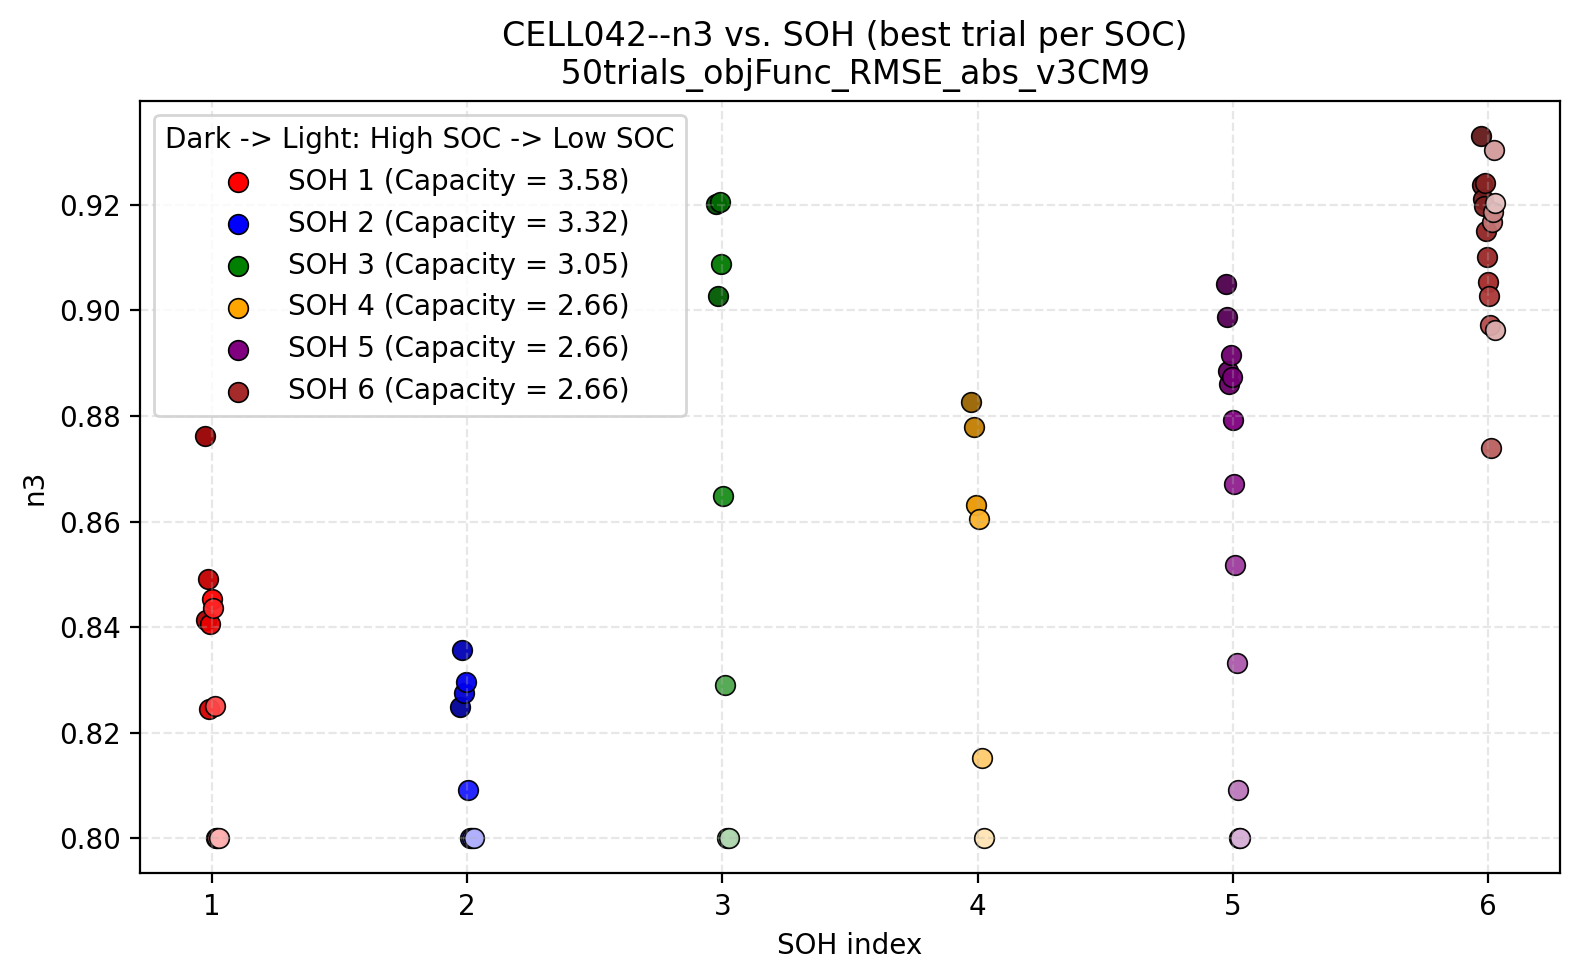

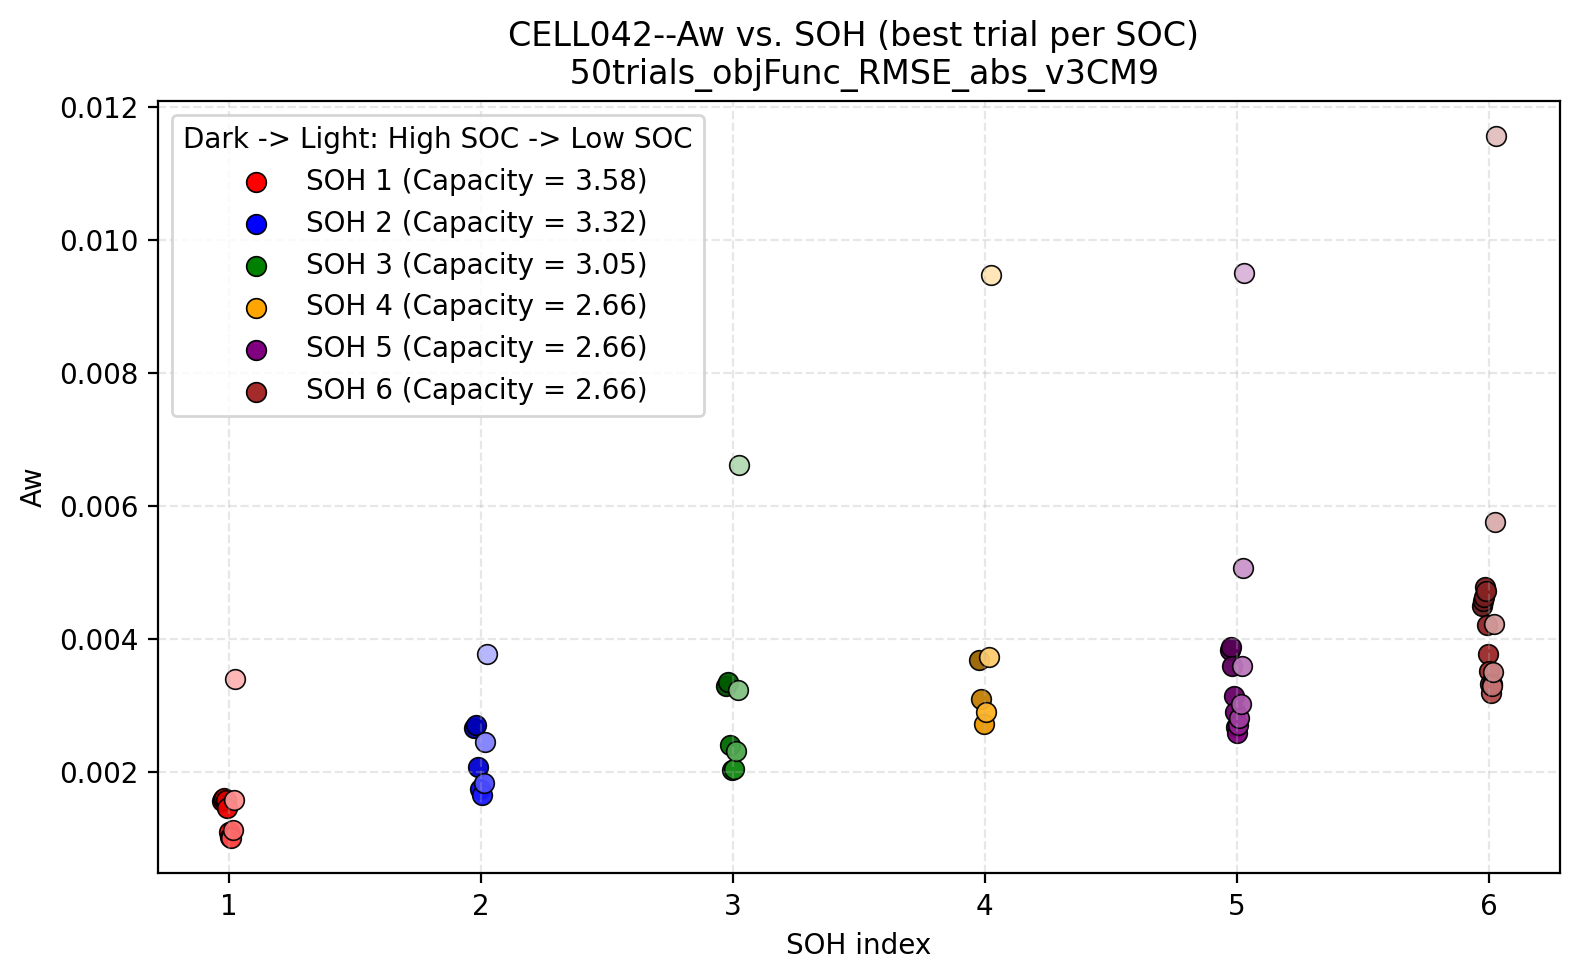

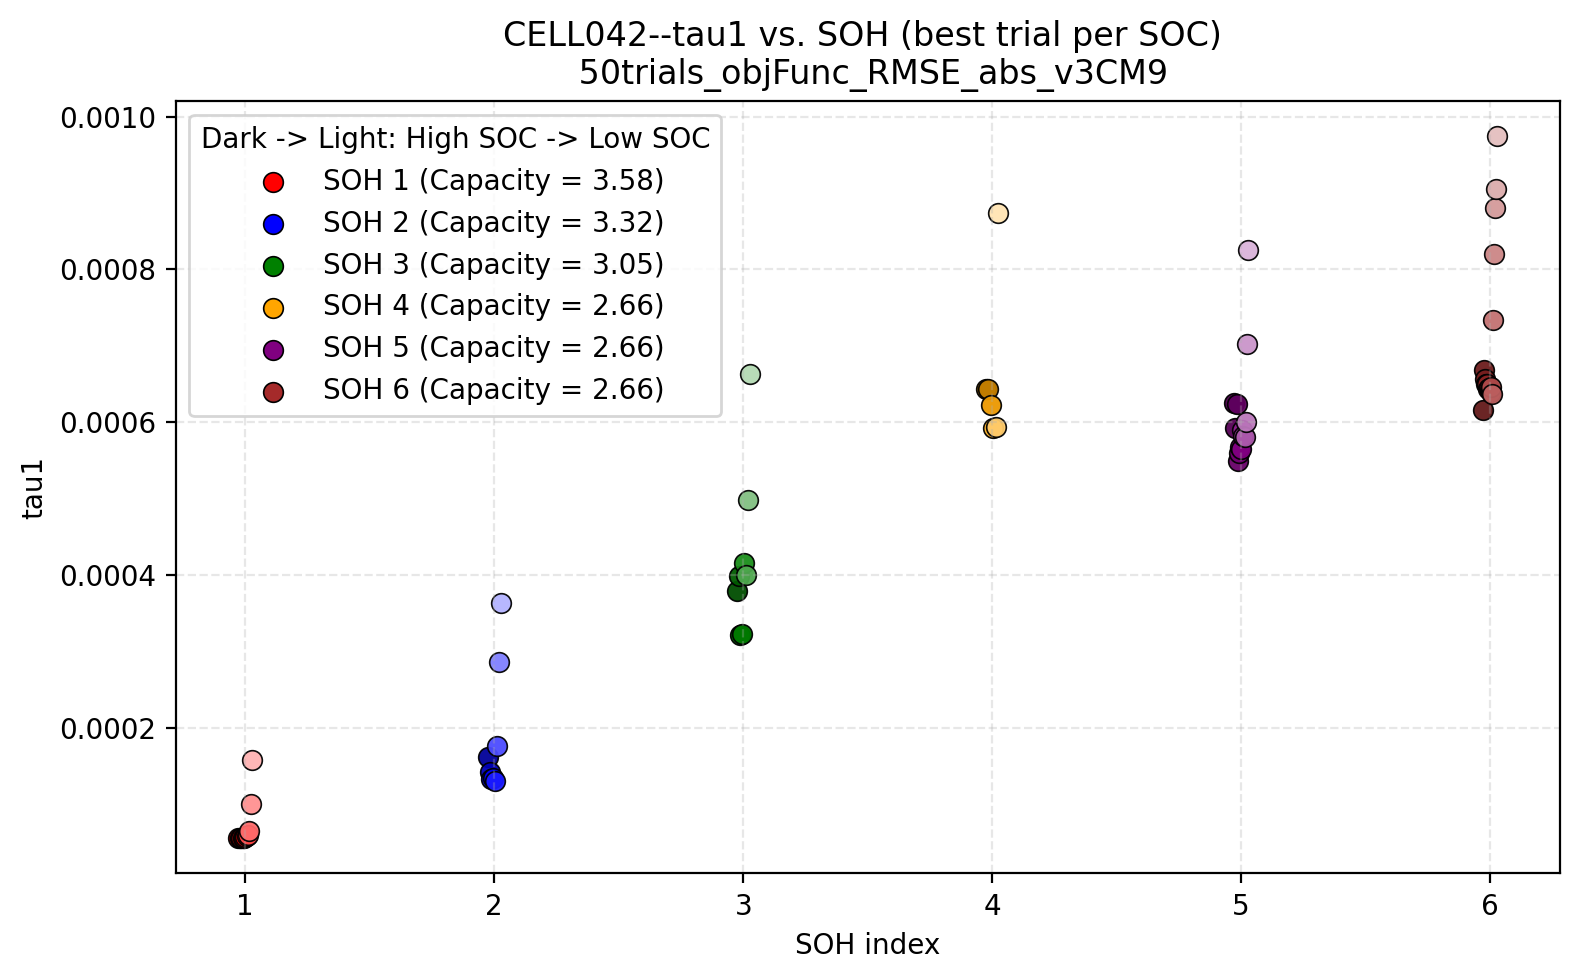

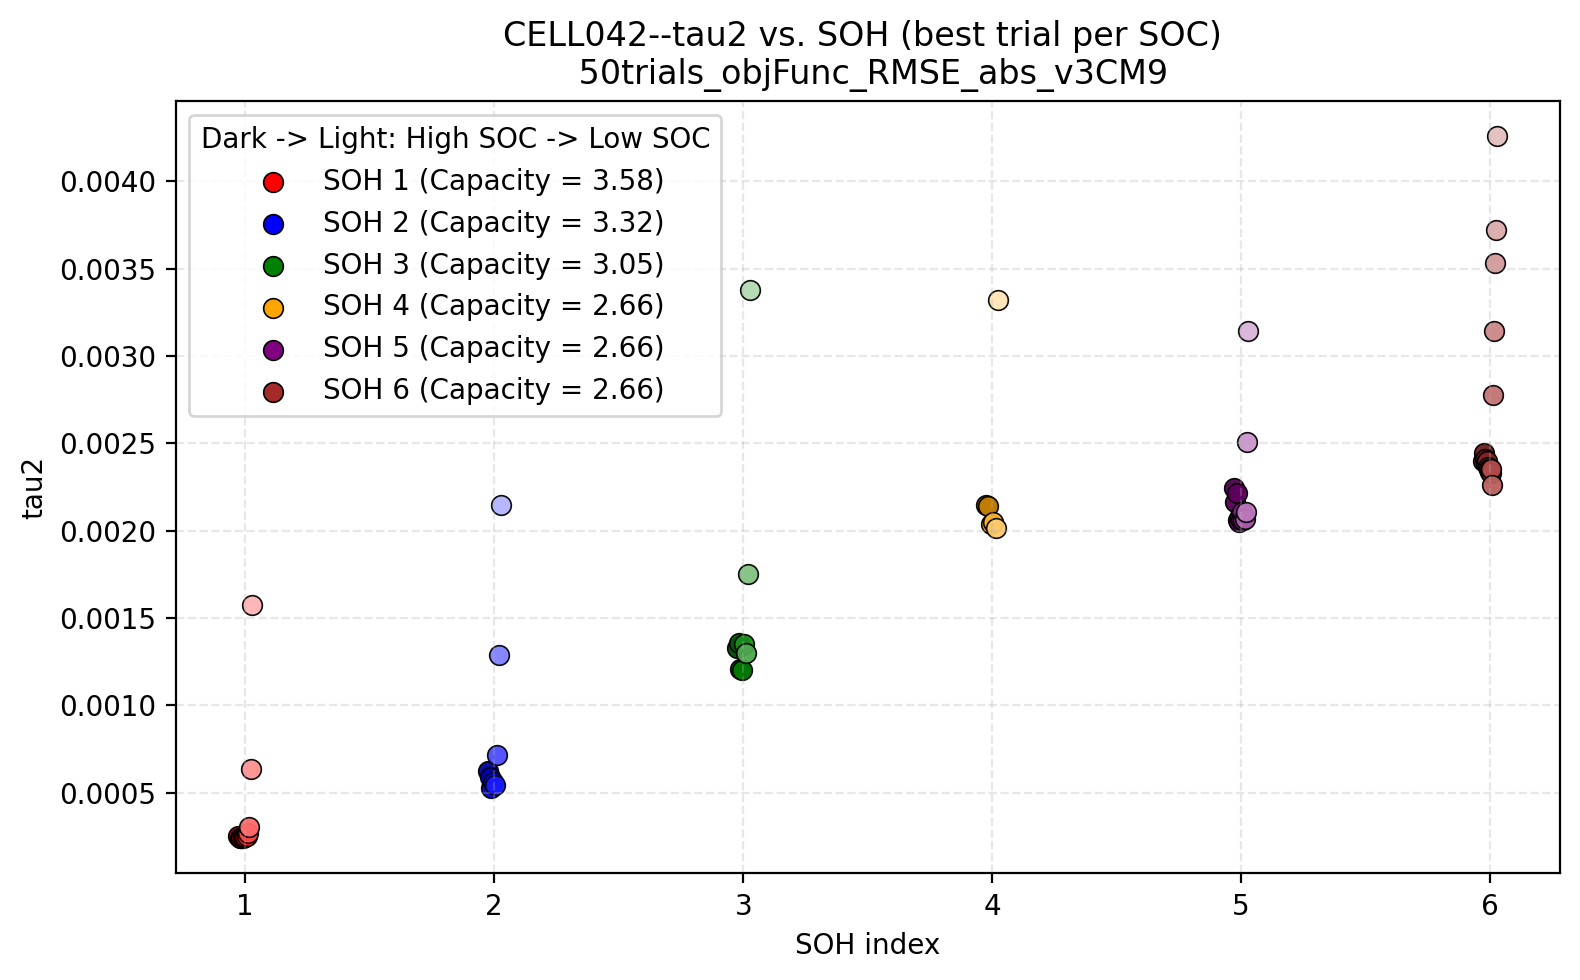

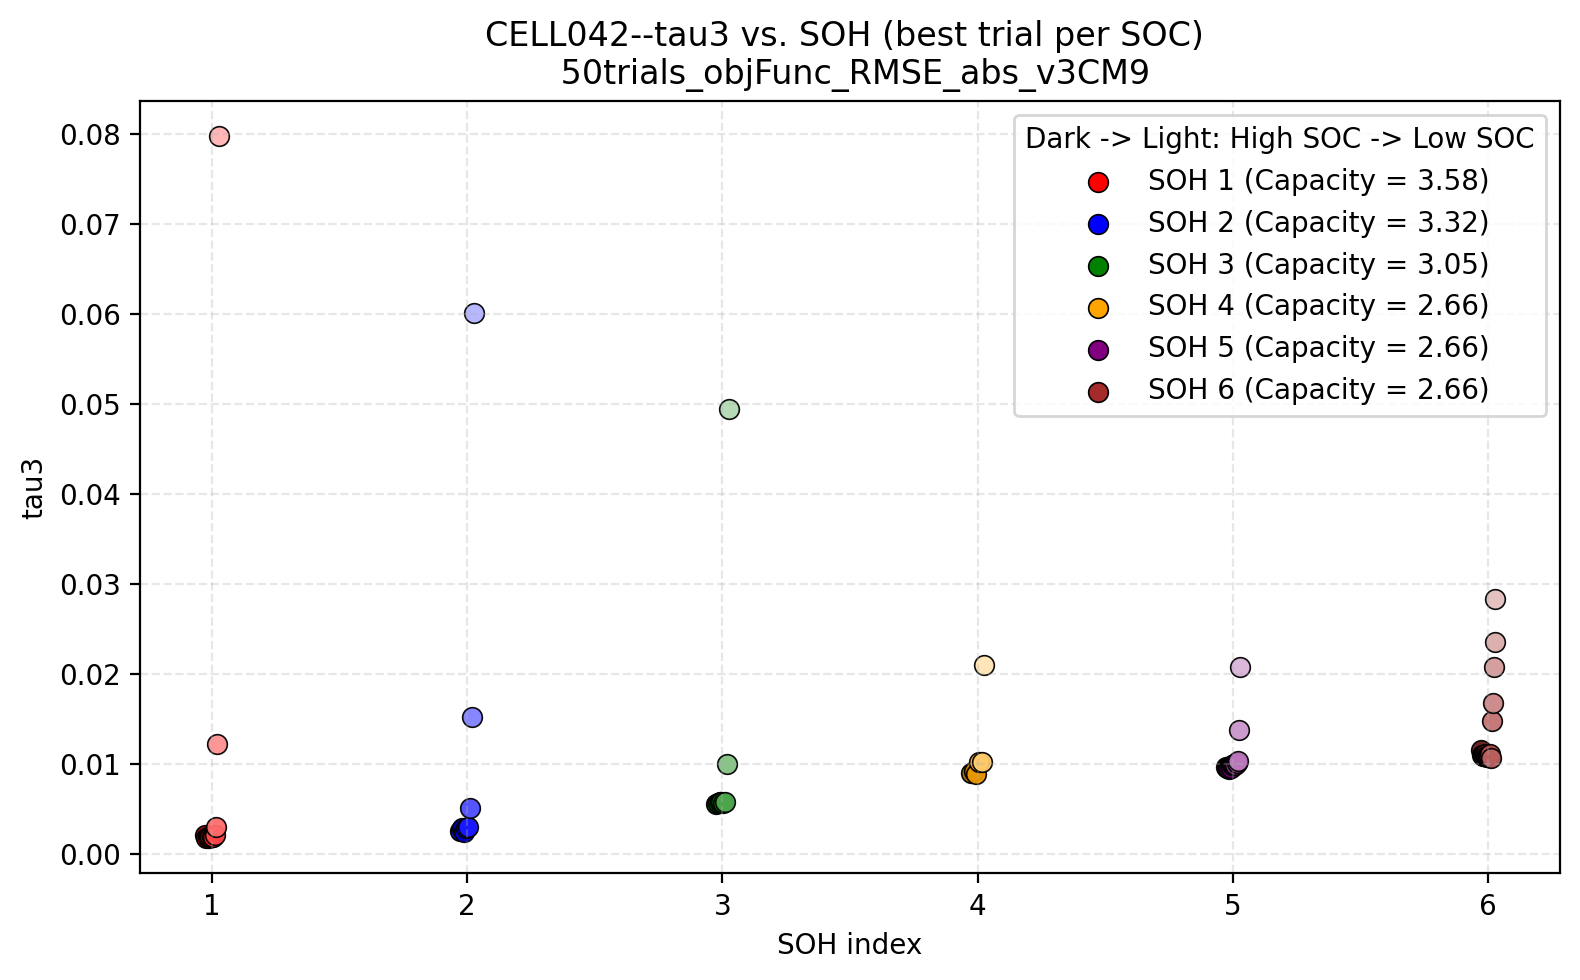

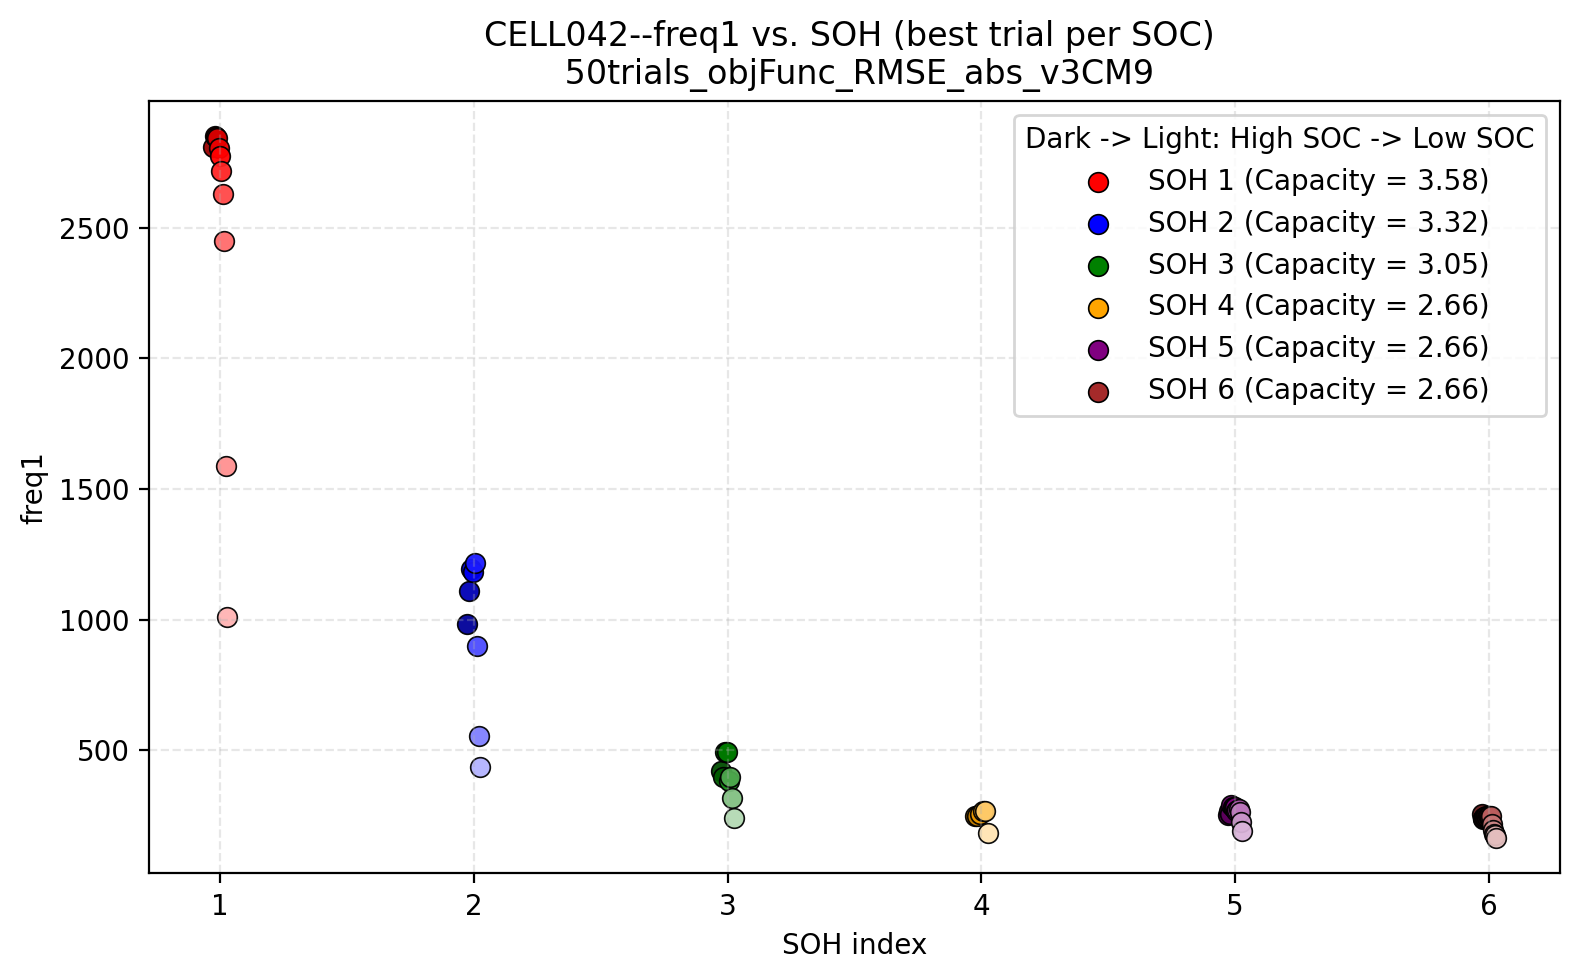

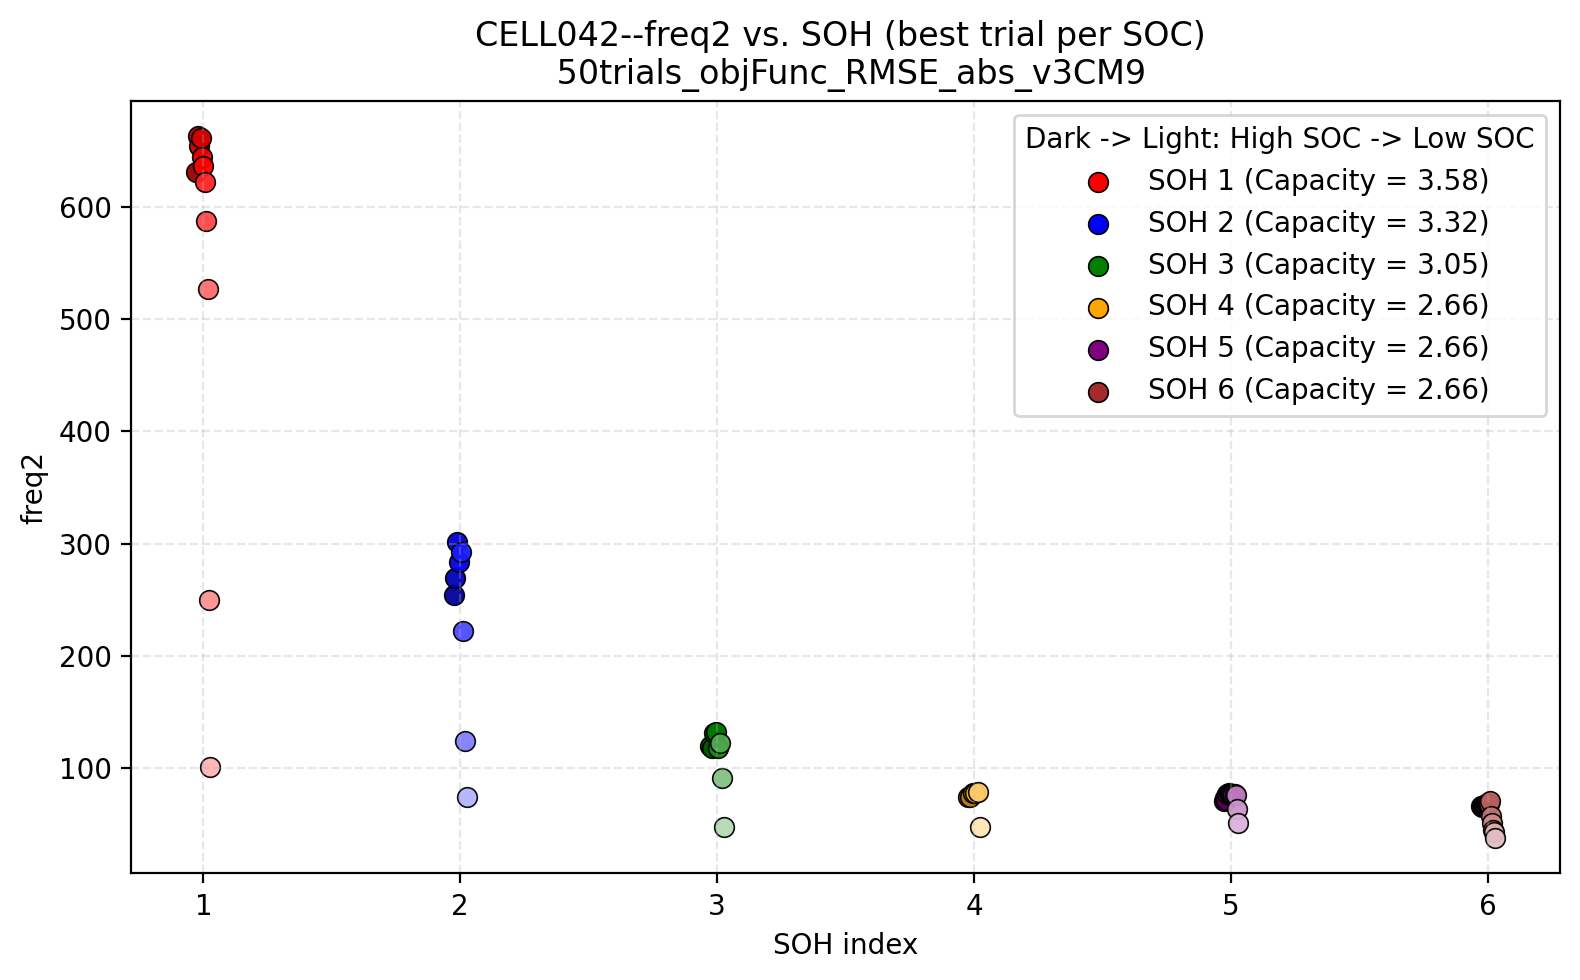

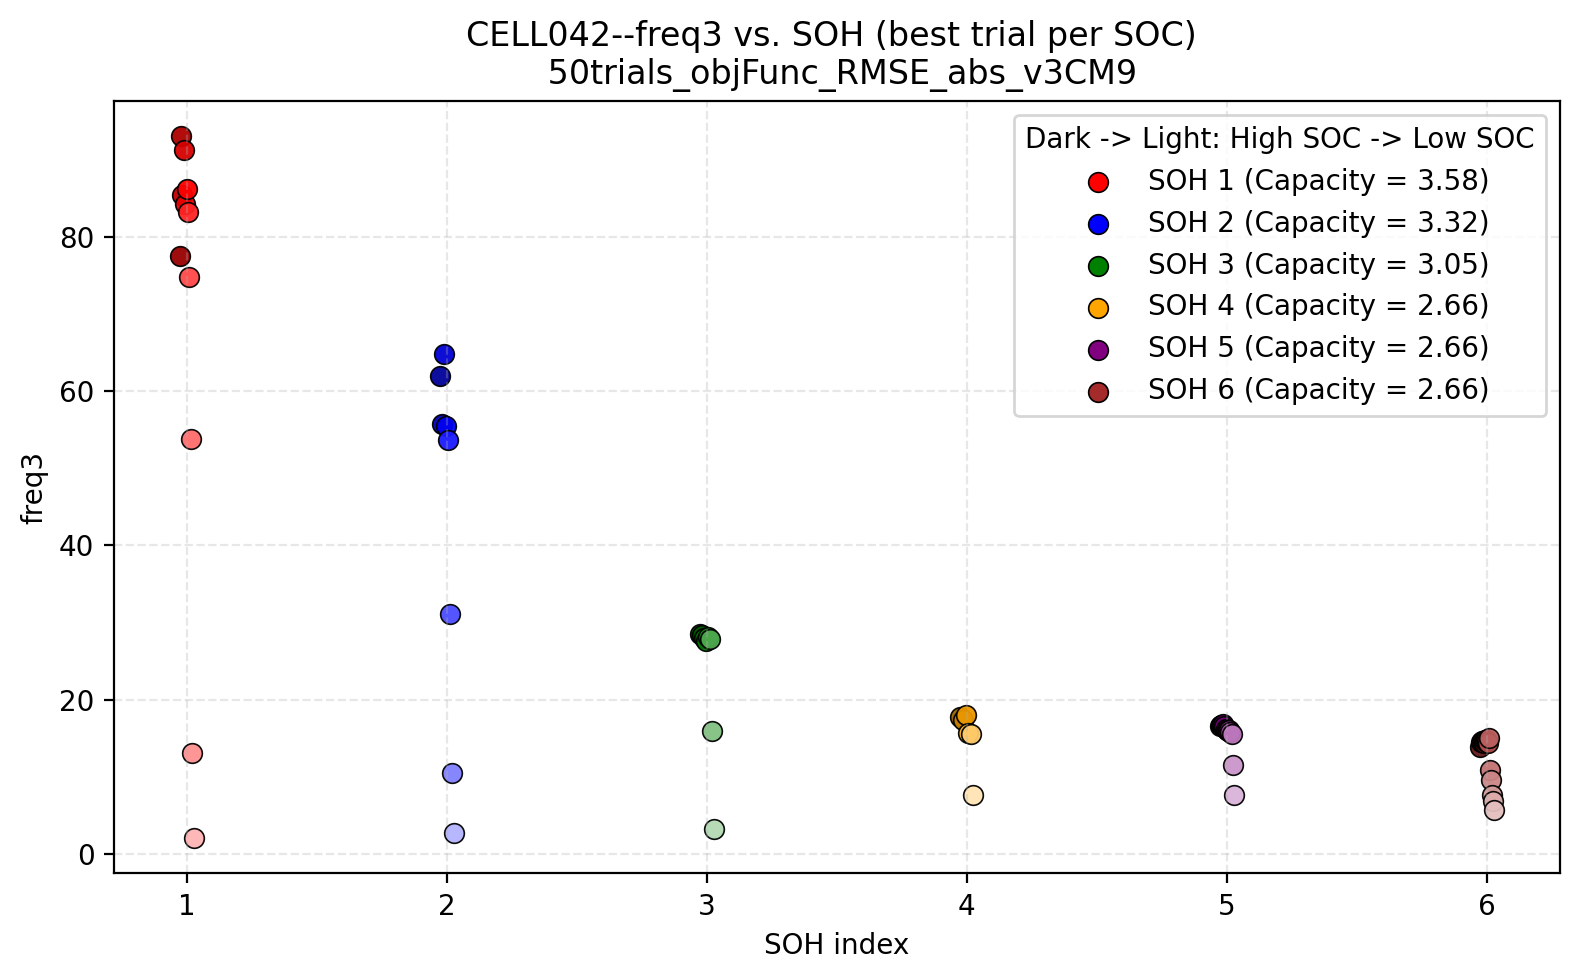

In [ ]:
obj_func = "RMSE_abs"
ECM_model_name = "v3CM9"
num_trials = 50

# ----------------------------------------------------------------------------------------
df = gather_best_trial_dataset("CELL042", obj_func, ECM_model_name, num_trials, cell42_metadata)

params_names = PARAMS_NAMES[ECM_model_name] + ["tau1", "tau2", "freq1", "freq2"]
if ECM_model_name == "v3CM9":
    params_names = PARAMS_NAMES[ECM_model_name] + ["tau1", "tau2",  "tau3", "freq1", "freq2", "freq3"]

# plot_param(df, "R0", cell42_metadata)
for p in params_names:
    plot_param(df,p, cell42_metadata, "CELL042", obj_func, ECM_model_name, num_trials)

#### EIS Reconstruction Nyquist Plot

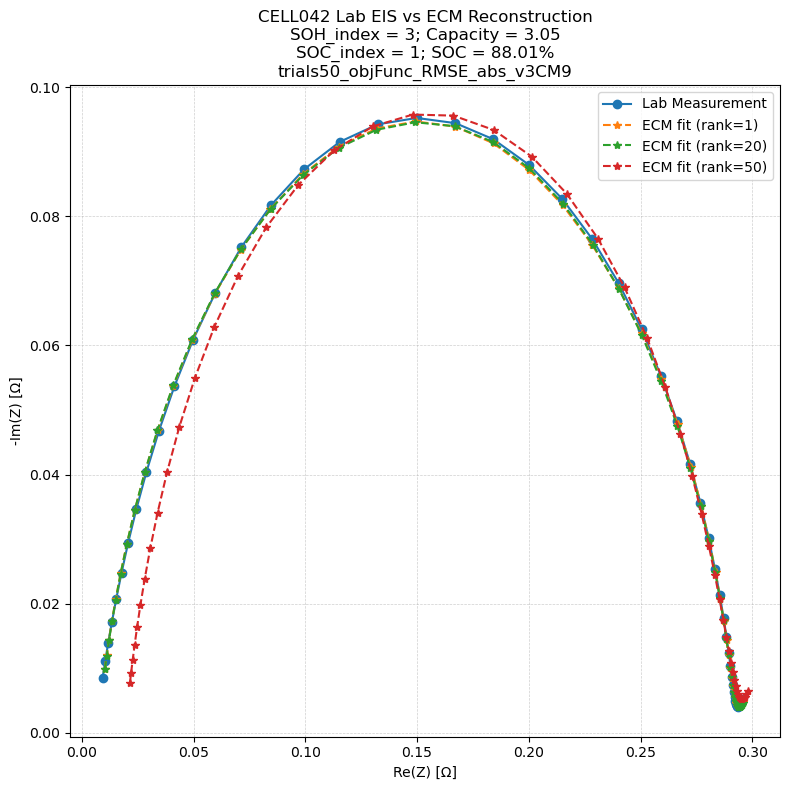

In [ ]:
battery_name = "CELL042"
soh_label = 3
soc_label = 1
ECM_name = "v3CM9"
obj_func = "RMSE_abs"
num_trials = 50

filepath = f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}/soh{soh_label}/{battery_name}_soh{soh_label}_soc{soc_label}_trials{num_trials}_objFunc_{obj_func}_{ECM_name}.csv"
subtitle = f"trials{num_trials}_objFunc_{obj_func}_{ECM_name}"

EIS_Nyquist_meas_vs_fit(battery_name, cell42_metadata, cell42_EISdata, soh_label, soc_label, ECM_name, filepath, select_est_ranks=[1,20,50], subtitle=subtitle)

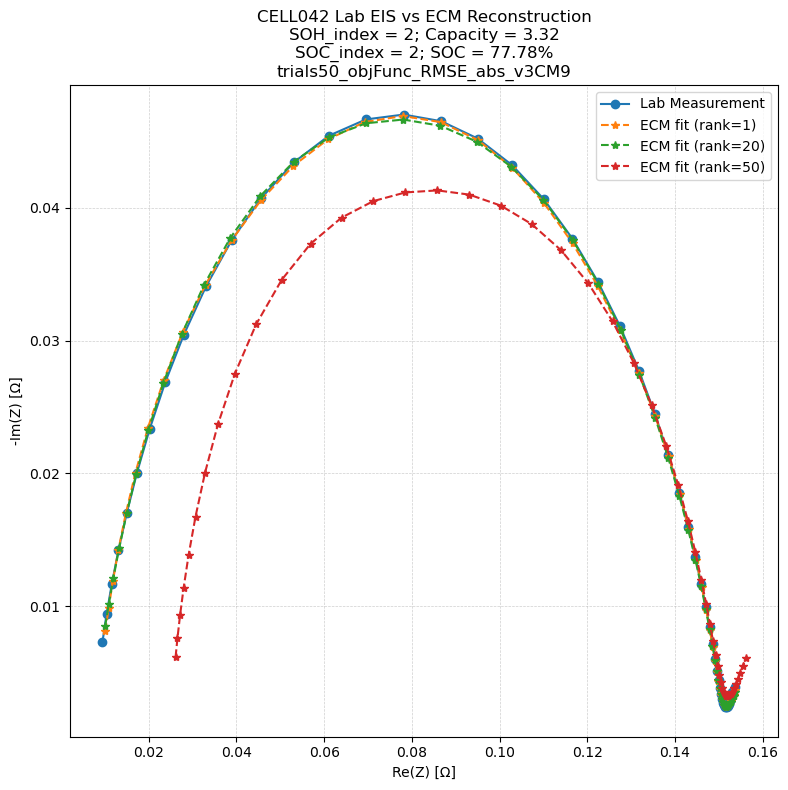

In [ ]:
battery_name = "CELL042"
soh_label = 2
soc_label = 2
ECM_name = "v3CM9"
obj_func = "RMSE_abs"
num_trials = 50

filepath = f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}/soh{soh_label}/{battery_name}_soh{soh_label}_soc{soc_label}_trials{num_trials}_objFunc_{obj_func}_{ECM_name}.csv"
subtitle = f"trials{num_trials}_objFunc_{obj_func}_{ECM_name}"

EIS_Nyquist_meas_vs_fit(battery_name, cell42_metadata, cell42_EISdata, soh_label, soc_label, ECM_name, filepath, select_est_ranks=[1,20,50], subtitle=subtitle)

#### Remove Outliers

In [ ]:
battery_name = "CELL042"
ECM_name = "v3CM7"
obj_func = "RMSE_abs"
num_trials = 50
param_col_names = PARAMS_NAMES[ECM_name]
output_dir =  f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}_rmOutliers/"


for soh_i in range(cell42_metadata["num_soh"]):
    soh_data = cell42_metadata["soh"][soh_i]
    for soc_i in range(soh_data["num_soc"]):
        print(f" ---- SOH {soh_i+1}, SOC {soc_i+1} ----")
        subfolder = os.path.join(output_dir, f"soh{soh_i+1}")
        os.makedirs(subfolder, exist_ok=True)
        filepath = f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}/soh{soh_i+1}/{battery_name}_soh{soh_i+1}_soc{soc_i+1}_trials{num_trials}_objFunc_{obj_func}_{ECM_name}.csv"
        remove_outliers(filepath, param_col_names, subfolder)


 ---- SOH 1, SOC 1 ----
Step 1: 39 rows kept after freq1 <= 10kHz
Step 2: 39 rows kept after filtering parameters >= 1e-6
Step 3: 37 rows kept after RMSE_abs <= 0.008
Step 4: 37 rows kept after R2_magnitude >= 0.9998
Filtered data saved to: ECM_Params_Estimation/CELL042/v3CM7_RMSE_abs_trials50_rmOutliers/soh1\CELL042_soh1_soc1_trials50_objFunc_RMSE_abs_v3CM7_rmOutliers.csv
 ---- SOH 1, SOC 2 ----
Step 1: 40 rows kept after freq1 <= 10kHz
Step 2: 40 rows kept after filtering parameters >= 1e-6
Step 3: 40 rows kept after RMSE_abs <= 0.008
Step 4: 40 rows kept after R2_magnitude >= 0.9998
Filtered data saved to: ECM_Params_Estimation/CELL042/v3CM7_RMSE_abs_trials50_rmOutliers/soh1\CELL042_soh1_soc2_trials50_objFunc_RMSE_abs_v3CM7_rmOutliers.csv
 ---- SOH 1, SOC 3 ----
Step 1: 34 rows kept after freq1 <= 10kHz
Step 2: 34 rows kept after filtering parameters >= 1e-6
Step 3: 33 rows kept after RMSE_abs <= 0.008
Step 4: 33 rows kept after R2_magnitude >= 0.9998
Filtered data saved to: ECM_Par

Remaing EIS Reconstruction Check

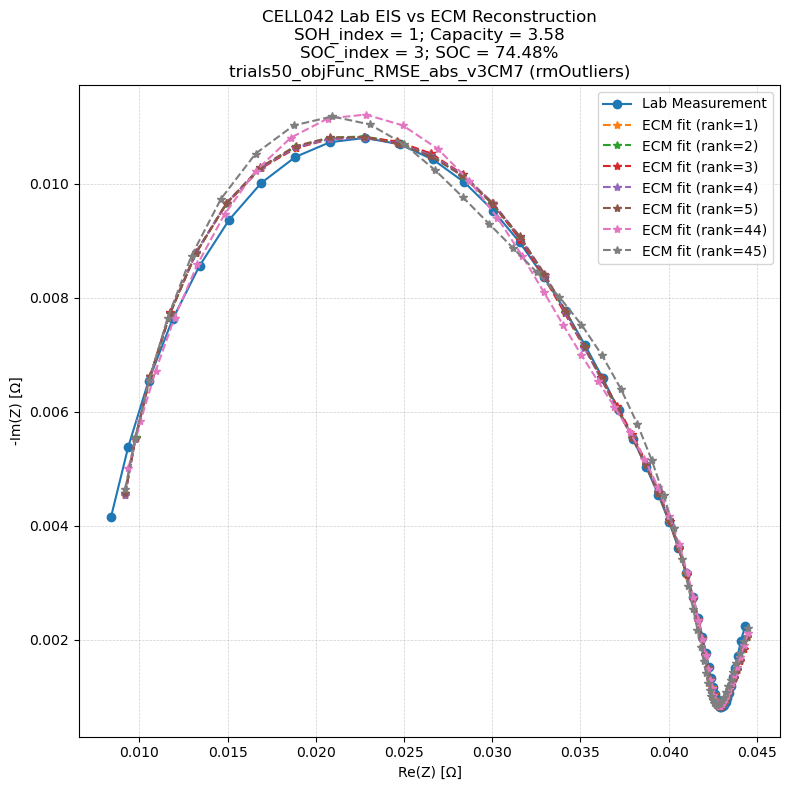

In [199]:
battery_name = "CELL042"
soh_label = 1
soc_label = 3
ECM_name = "v3CM7"
obj_func = "RMSE_abs"
num_trials = 50

filepath = f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}/soh{soh_label}/{battery_name}_soh{soh_label}_soc{soc_label}_trials{num_trials}_objFunc_{obj_func}_{ECM_name}.csv"
subtitle = f"trials{num_trials}_objFunc_{obj_func}_{ECM_name} (rmOutliers)"

df = pd.read_csv(filepath)
select_ranks = df["trial_rank"].values
# print(select_ranks)
EIS_Nyquist_meas_vs_fit(battery_name, cell42_metadata, cell42_EISdata, soh_label, soc_label, ECM_name, filepath, select_est_ranks=[1,2,3,4,5,44,45], subtitle=subtitle)

** For SOH=6, SOC=16, all results not good on warburg tail part

Manully Inspection Remove

In [176]:
# (soh, soc): [ranks to be removed]
remove_EIS_check_v3CM7 = {
    (1, 1): [42,45,46,47],
    (1, 2): [44,47],
    (1, 3): [46],
    (1, 4): [43,44],
    (1, 5): [25, 39, 42],
    (1, 7): [27],
    (1, 8): [44, 45],
    (1, 9): [33, 38],
    (1, 10): [40, 41],
    (1, 11): [38],
    (2, 6): [47,48],
    (2,7): [45],
    (2,8): [33, 34],
    (3,2): [48, 49],
    (3,6): [48],
    (3,8): [46, 47],
    (4,6): [49],
    (6,7): [50]
}


battery_name = "CELL042"
ECM_name = "v3CM7"
obj_func = "RMSE_abs"
num_trials = 50
param_col_names = PARAMS_NAMES[ECM_name]
input_dir = f"ECM_Params_Estimation/{battery_name}/{ECM_name}_{obj_func}_trials{num_trials}_rmOutliers/"

print("===== Manully Remove after inspection =====")
for soh_i in range(cell42_metadata["num_soh"]):
    soh_data = cell42_metadata["soh"][soh_i]
    for soc_i in range(soh_data["num_soc"]):
        print(f" ---- SOH {soh_i + 1}, SOC {soc_i + 1} ----")

        folder = os.path.join(input_dir, f"soh{soh_i + 1}")
        filepath = os.path.join(
            folder,
            f"{battery_name}_soh{soh_i + 1}_soc{soc_i + 1}_trials{num_trials}_objFunc_{obj_func}_{ECM_name}_rmOutliers.csv"
        )

        if os.path.exists(filepath):
            df = pd.read_csv(filepath)

            # Remove specified trial ranks
            key = (soh_i + 1, soc_i + 1)
            if key in remove_EIS_check_v3CM7:
                ranks_to_remove = remove_EIS_check_v3CM7[key]
                print(f"For SOH = {soh_i + 1}, SOC = {soc_i+1}, Remove trial_rank = {ranks_to_remove}")
                df = df[~df["trial_rank"].isin(ranks_to_remove)]

            # Overwrite the original file
            df.to_csv(filepath, index=False)
        else:
            print(f"File not found: {filepath}")


===== Manully Remove after inspection =====
 ---- SOH 1, SOC 1 ----
For SOH = 1, SOC = 1, Remove trial_rank = [42, 45, 46, 47]
 ---- SOH 1, SOC 2 ----
For SOH = 1, SOC = 2, Remove trial_rank = [44, 47]
 ---- SOH 1, SOC 3 ----
For SOH = 1, SOC = 3, Remove trial_rank = [46]
 ---- SOH 1, SOC 4 ----
For SOH = 1, SOC = 4, Remove trial_rank = [43, 44]
 ---- SOH 1, SOC 5 ----
For SOH = 1, SOC = 5, Remove trial_rank = [25, 39, 42]
 ---- SOH 1, SOC 6 ----
 ---- SOH 1, SOC 7 ----
For SOH = 1, SOC = 7, Remove trial_rank = [27]
 ---- SOH 1, SOC 8 ----
For SOH = 1, SOC = 8, Remove trial_rank = [44, 45]
 ---- SOH 1, SOC 9 ----
For SOH = 1, SOC = 9, Remove trial_rank = [33, 38]
 ---- SOH 1, SOC 10 ----
For SOH = 1, SOC = 10, Remove trial_rank = [40, 41]
 ---- SOH 1, SOC 11 ----
For SOH = 1, SOC = 11, Remove trial_rank = [38]
 ---- SOH 2, SOC 1 ----
 ---- SOH 2, SOC 2 ----
 ---- SOH 2, SOC 3 ----
 ---- SOH 2, SOC 4 ----
 ---- SOH 2, SOC 5 ----
 ---- SOH 2, SOC 6 ----
For SOH = 2, SOC = 6, Remove trial

#### Boxplots

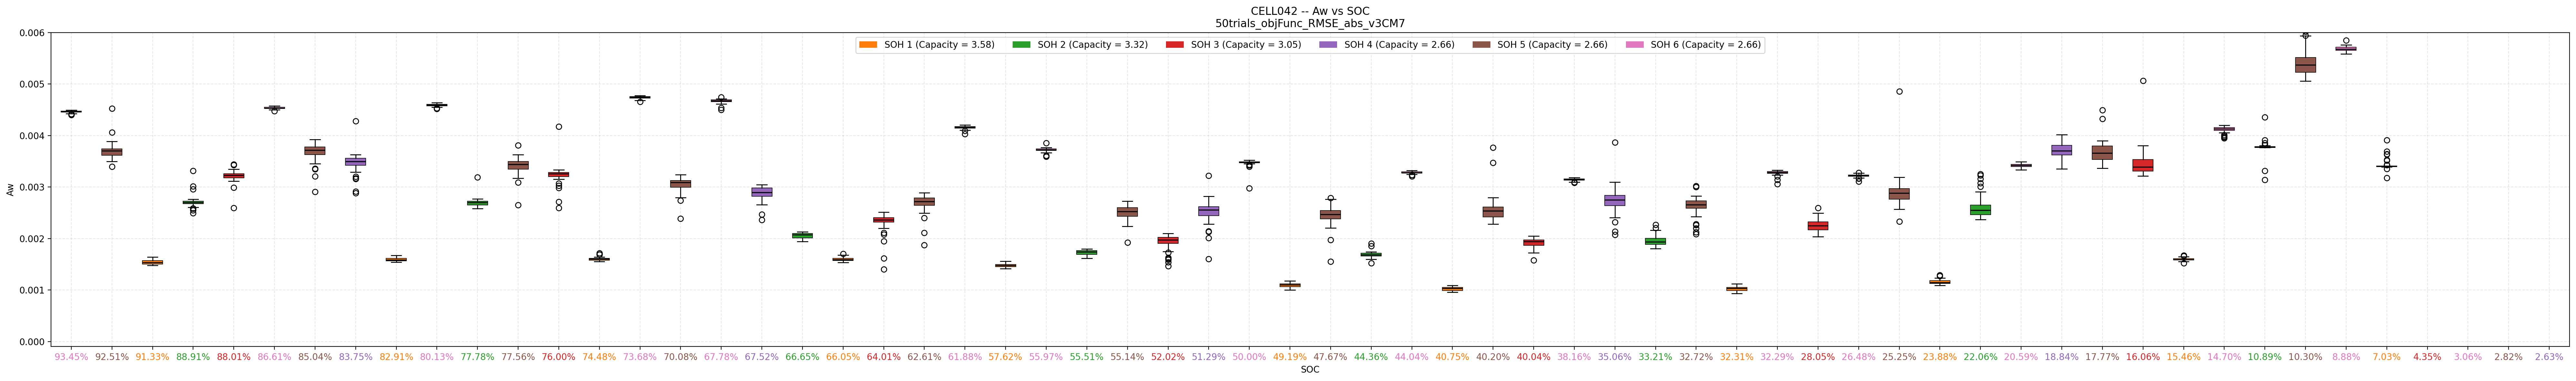

In [203]:
obj_func = "RMSE_abs"
ECM_model_name = "v3CM7"
num_trials = 50

# ----------------------------------------------------------------------------------------
df = gather_all_trials_dataset("CELL042", obj_func, ECM_model_name, num_trials, cell42_metadata, "rmOutliers")
# print(df["soc"].unique())
# print("Number of unique SOC values:", df["soc"].nunique())
# group_counts = df.groupby(["soh_label", "soc"]).size().reset_index(name="count")
# print(group_counts.sort_values(by="count"))

params_names = PARAMS_NAMES[ECM_model_name] + ["tau1", "tau2", "freq1", "freq2"]
if ECM_model_name == "v3CM9":
    params_names = PARAMS_NAMES[ECM_model_name] + ["tau1", "tau2",  "tau3", "freq1", "freq2", "freq3"]

# plot_param(df, "R0", cell42_metadata)
for p in ["Aw"]:
    plot_param_boxplot_by_soc(df, p, cell42_metadata, "CELL042", obj_func, ECM_model_name, num_trials)